# Projet Finance 

### Introduction: Problématique métier

Nous sommes dans le secteur bancaire et plus précisément dans l’attribution de prêt a des clients d’une banque. Le but de ce projet est de prévoir si tel ou tel client est autorisé à contracter un prêt. 
En d’autres terme classer nos clients en deux groupes distincts :
    • Autorisé à contracter un prêt
    • Non-autorisé
Pour ce faire la banque possède un certain nombre d’information sur le comportement de ces clients ou leurs informations personnelles.

### Traduction Machine Learning

Au vu de la problématique métier on est dans le cas d’un problème supervisé de Machine Learning et plus précisément dans un cas de classification. 

Nous pouvons donc imaginer partir sur des modèles tel que des Decision Tree (Classifier), des random forest et autres Xgboost.

Les metrics pour évaluer nos modèles sont dans ce cas l’accuracy, le recall ou encore la précision. 

<font color="green">Il faut peut-être voir avec le client si il préfère privilégier le fait de n’omettre aucun client qui puisse théoriquement contracté un prêt (Au risque d’augmenter l’accession au crédit à des clients à risque).  Ou au contraire si il veut minimiser les clients à risque au détriment de clients potentiellement viable
</font> 

En fonction de cette réponse on privilégiera :
    • Le score de « Recall » dans le premier cas.
    • Le score de « Precision » dans le second cas. 
    • Autrement on peut-équilibrer cela grace au F1 score.

<font color= "green">Il pourrait être intéressant de savoir si la banque à un seuil de clients à risque qu’elle accepte de prendre  car cela pourrait nous permettre de fixer un seuil de recall / precision qui conviennent à ces attentes. </font>

## Importation library

In [358]:
# Librairie général de python pour des opération communes
import pandas as pd
import numpy as np
#from pandasgui import show # Fonction permettant une visualisation approfondie 
#d'une dataframe pandas sur un interface graphique avancée. Mis en commentaire car probléme d'installation.


#Librairie de visualisation principale
import seaborn as sns 
import matplotlib.pyplot as plt
import graphviz
import missingno as msno
import scipy as scp



# Sklearn sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler


#Sklearn preprocessing 
from sklearn.preprocessing import LabelEncoder #Encode les labels
from sklearn.preprocessing import OneHotEncoder #Permet d'indentifier et de modifier nos variables qualitative.

#Sklearn Feature Selection
from sklearn.feature_selection import SelectKBest,f_classif,chi2 #Etude des variables, test du Chi2 et test anova

#Sklearn PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

#Split

from sklearn.model_selection import train_test_split


#Modèles de machine learning

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm as svml 
from sklearn import tree

#Nos metrics

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,confusion_matrix, classification_report

#Importer notre modèle
import pickle 


import warnings
warnings.filterwarnings('ignore')

## Sommaire

- [1 : Importation des données](#1)
- [2 : Compréhension des données](#2)
- [3: Première visualisation](#3)
- [4: Visualisation Valeurs Manquante](#4)
- [5: Nettoyage des données](#5)
- - [5.1: Gestion Nan: Variables qualitatives](#6)
- - [5.2: Gestion Nan: Variables quantitatives](#7)
- [6: Nettoyage des données : Modification des types](#8)
- - [6.1: Variable Qualitative: One Hot Encoder](#9)
- [7: Seconde visualisation](#11)
- - [7.1: Variable Qualitative](#12)
- - [7.2: Variable Quantitative](#13)
- - [7.3: Nettoyage Outlier](#14)
- - [7.4: Etudes des Variables K-Best](#15)
- [8: Création de Features](#16)
- [9: Equilibrage](#17)
- [10: PCA](#18)
- [11: Normalisation](#19)
- [12: Modélisation](#20)
- - [12.1: Choix du modéle / Fonction](#21)
- - [12.2: Full Data Modeling](#22)
- - [12.3: Only Best Features](#23)
- - [12.4: Partial Data Modeling](#24)
- [13: Analyse des résultats](#25)
- [14: Exportation du model](#26)




### <a id='1'><center><font color="INDIANRED">1) Importation des données</font></center></a>

Nous avons deux dataset "différents" stocké avec deux méthodes différentes examinons tout d'abords les différences entre ces deux fichier. 

### Comparaison des datasets

In [359]:
df_csv= pd.read_csv('train.csv')
df_xls=pd.read_excel('train.xlsx')

On visualise d'abords nos deux DF de manière supperficielle  pour voir si les deux correpondent.

In [360]:
df_csv

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [361]:
df_xls

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


On vérifie la liste de nos colonnes. 

In [362]:
print(df_csv.columns)
print(df_xls.columns)

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')
Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')


On continue notre exploration en regardant le type et le nombre de valeurs réel de nos datasets

In [363]:
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [364]:
df_xls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Enfin on vérifie les grands indicateurs statistique de nos données numétiques. 

In [365]:
df_csv.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [366]:
df_xls.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


### Conclusion

Les deux datasets présente des carractéritiques similaire :
<ul><li>Même nombre de colonnes </li>
    <li>Même nombre de lignes</li>
    <li>Même nombre de valeurs manquante</li>
    <li>Indicateurs statistiques égaux</li>
On peut donc partir du postulat que nos datasets sont identiques nous ne travaillerons donc que sur le dataset en csv 

### <a id='2'><center><font color="INDIANRED">2) Compréhension des données</font></center></a>

### Compréhension des variable

In [367]:
df=df_csv

In [368]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [369]:
df.Credit_History.unique()

array([ 1.,  0., nan])

In [370]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Nous avons donc 13 colonnes dans ce dataset dont une target (Loan_Status):

<b>Variables Indépendante</b>
<ul><li> Loan_ID : Un ID représentant uniquement chaque clients (Type: String)</li>
    <li>Gender : Le genre de notre client (Type: String) </li>
    <li>Married: Booleen représentant si notre client est marié(e) ou non (Type: Bool) </li>
    <li>Dependents: nombre de personne à charge sur le client (Type: Integer) </li>
    <li> Education: Booleen représentant si la personne est diplomé ou non (Type: Bool) </li>
    <li>Self_Employed: Booleen représentant si la personne est auto entrepreuneur (Type: bool) </li>
    <li>ApplicantIncome: Les revenus du client (Type: Float) </li>
    <li>CoapplicantIncome: Les revenus d'une personne associé au client (Mari / femme, parents...) (Type: Float)</li>
    <li>LoanAmount: Montant de l'emprunt (En centaine) (Type: Float)</li>
    <li>Loan_Amount_Term: Montant des remboursement par mois(Type: Float) </li>
    <li>Credit_History: existe-il des antécédants de crédit.(Type: Bool)</li>
    <li>Property_Area: La zone de l'habitation. (Type: String) </li></ul>

<b>Notre Target</b>

<ul><li>Loan_Status: Représente si un crédit est accordé ou non en fonction des autres variables indépendantes</li></ul>

### <a id='3'><center><font color="INDIANRED">3)Première visualisation</font></center></a>

### Visualisation univarié

Voyons les répartition de nos différents groupe

In [371]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Variable quantitative

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

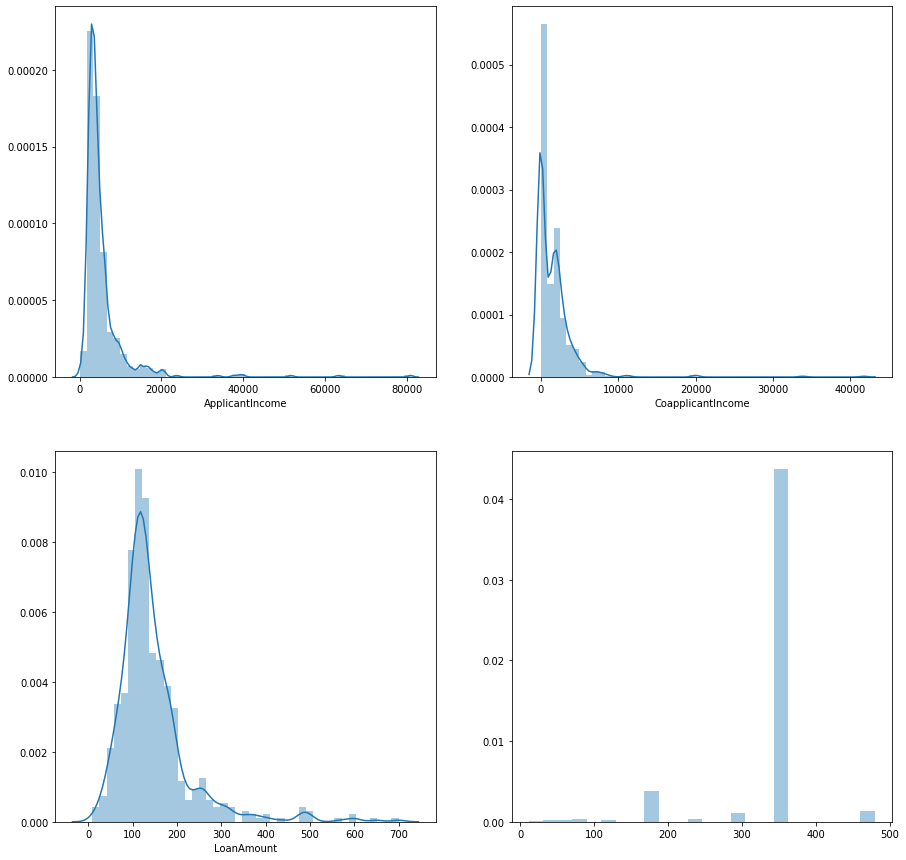

In [372]:
num_feature=[6,7,8,9] #Les indexs des variables numétiques. 
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,15))#On fixe notre subplot
for x, ax in zip(num_feature, axes.flat): #On passe en revue toute nos colonnes 
    sns.distplot(df.iloc[:,x],ax=ax) #On affiche des distplot pour chacune des variable numérique. 
plt.show()

Avec ces graphique on repére une grosse tendance concernant les mensualité et l'income. Celà ce reflète par un gros pic de densité. Le LoanAmount est plus étendue avec un pic à 180 a peu près. Pour le CoapplicantIncome la forte présence de 0 (C'est à dire l'absence de revenu secondaire), nuit grandement à la lisibilité du graphique. A noter également que pour l'instant on ne peut pas visualiser les données concernant les Dependants a cause de la présence de +3

### Variable qualitatif

TypeError: 'str' object is not callable

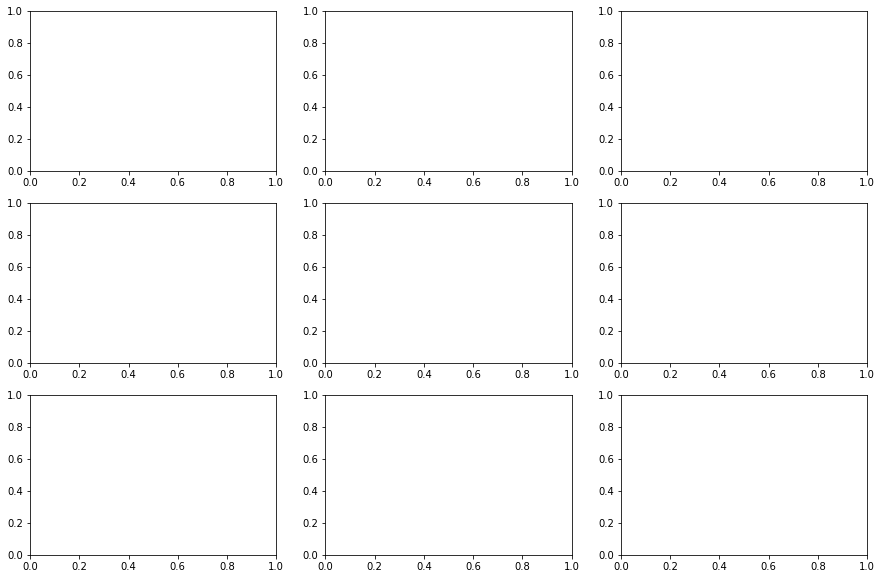

In [376]:
cat_feature=[1,2,3,4,5,10,11] # Les indexs de nos variable qualitatif (Hors Target)

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15,10)) # Même principe que pour la boucle précédente mais avec un countplot
plt.suptitle('Répartition des variables')
for x, ax in zip(cat_feature, axes.flat):
    sns.countplot(df.iloc[:,x],ax=ax)
plt.show()

Ici on a une visualisation de nos données catégorical et la répartition de nos données dans ces catégories. On a pas de belle parité dans nos données mais étant donné qu'il ne s'agit pas de notre target ce n'est pas important d'équilibré ces variables.  

### Target

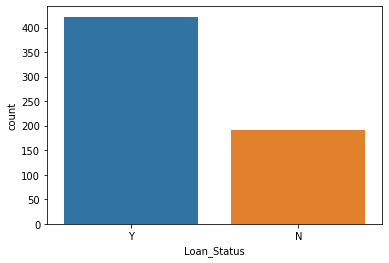

In [377]:
#Visualisation de notre target.
sns.countplot(df.Loan_Status)

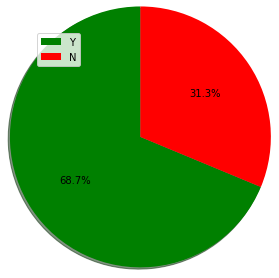

In [378]:
#Représentation en pie plot pour avoir une vue des proportions en %.

plt.pie(x=df['Loan_Status'].value_counts(), autopct="%1.1f%%", shadow=True,
        startangle=90, radius=1.5, colors = ['Green', 'Red'])
plt.legend(labels=df['Loan_Status'])
plt.show()

Ici on remarque un petit déséquilibre dans nos targets qu'il faudra peut-être palier ce n'est pas forcément obligatoire avec 30%

### <a id='3'><center><font color="INDIANRED">4) Visualisation valeurs manquantes</font></center></a>

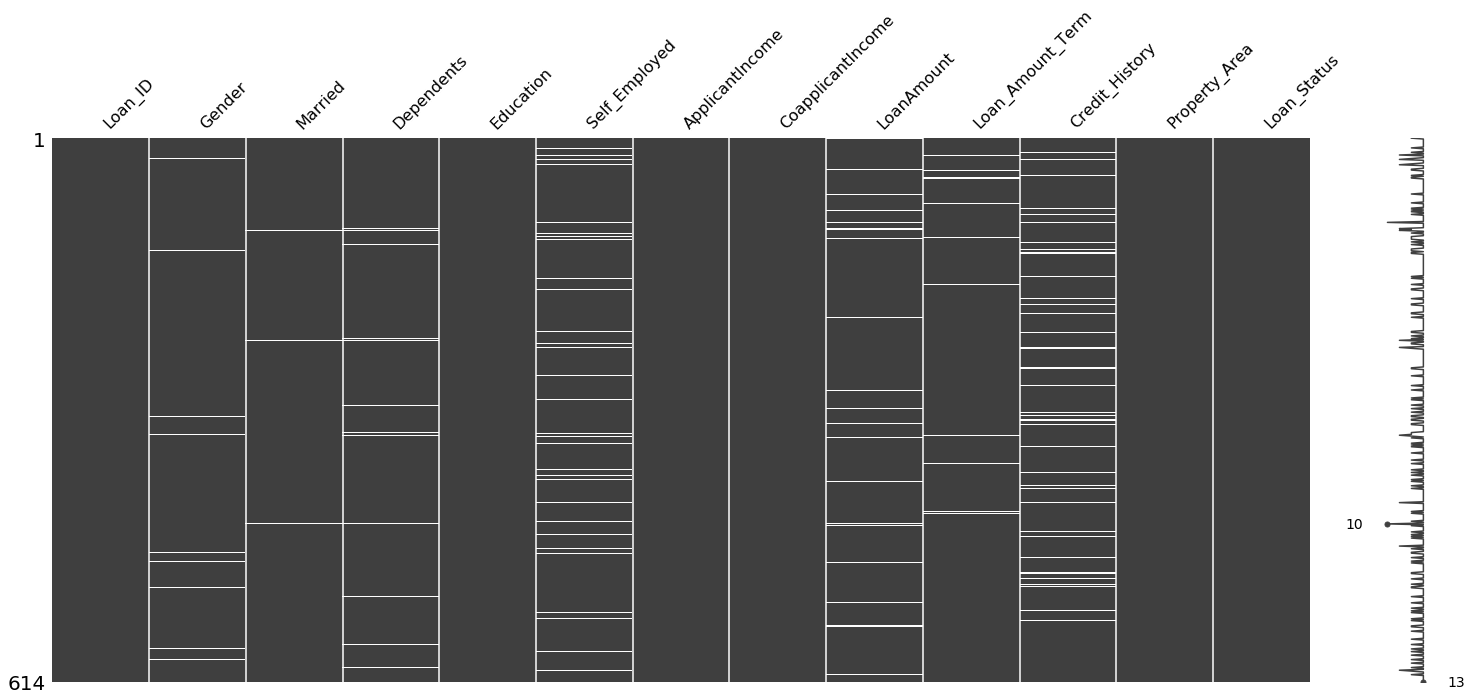

In [379]:
msno.matrix(df)
#Représente visuelement les valeurs manquante en blanc.

In [380]:
# Le nombre de valeurs null par colonne. 
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [381]:
df.isnull().sum()/len(df)*100

Loan_ID              0.000000
Gender               2.117264
Married              0.488599
Dependents           2.442997
Education            0.000000
Self_Employed        5.211726
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       8.143322
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

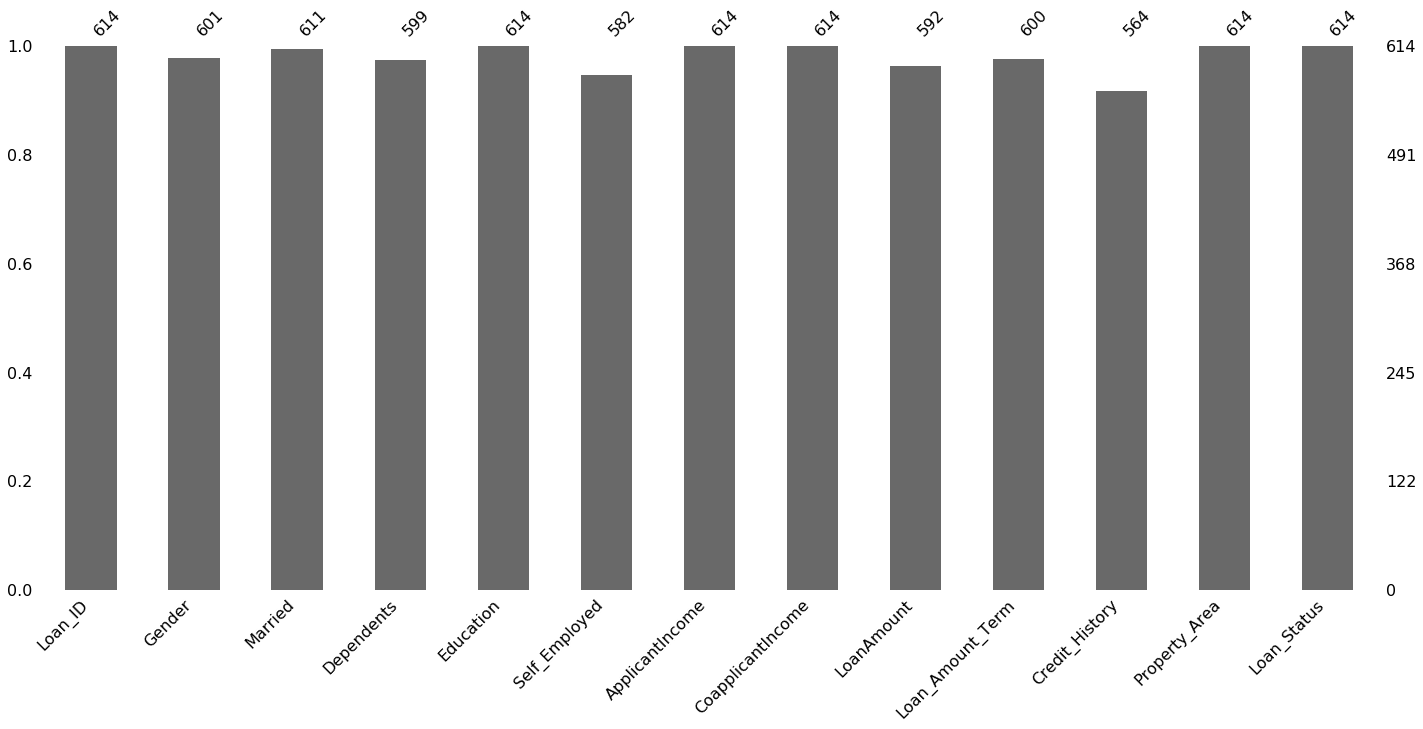

In [382]:
msno.bar(df)

Cette représentation représente le nombre de valeur non-null dans le dataset.

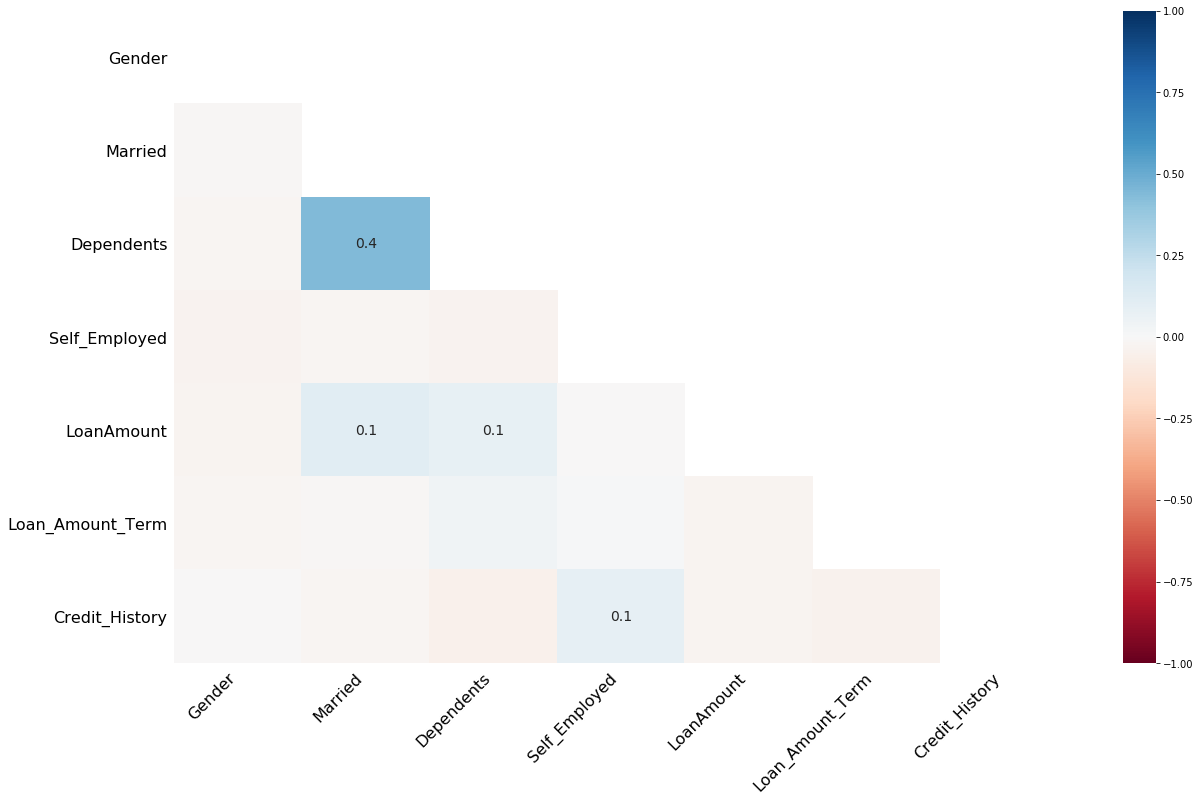

In [383]:
msno.heatmap(df)

Cette visualisation peut être intéressessante mais j'ai encore du mal à l'analyser. Il est censé représenté le liens entre l'absence de variable. 

1 représente que la présence d'une variable implique la présence d'une variable.
-1 représente que la présence d'une variable implique l'absence de l'autre variable. 

#### Conclusion
Nous avons donc 7 colonnes avec des valeurs null à traiter avant de poursuivre: 
<ul><li>Gender</li>
    <li>Married</li>
    <li>Dependants</li>
    <li>Self_Employed</li>
    <li>Loan_amount</li>
    <li>Loan_amount_term</li>
    <li>Credit History</li>

### <a id='5'><center><font color="INDIANRED">5) Nettoyage des données - Gestion des Valeurs Manquante</font></center></a>

Maintenant il va nous falloir élaborer des stratégies pour enlever ces NaN. Chaque variable aura un traitement particulier pour garder un maximum la précision de nos données.   

In [384]:
df_cln0= df.copy()
df_cln0.isnull().sum()
#On créer un nouveau df pour travailler (Etant donné que l'on va changé beaucoup de chose à partir de là).
#On itérera cette variable (df_cln1, dfcln2...) a chaque changement. 

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

### <a id="6">Variable Qualitatif</a>

#### Gender
Ici il y a deux possibilités : Male or Female. 
Difficile de prédire cette valeurs en fonction des autres variable car cette variable est théoriquement indépendante. Je vais donc remplacer par une valeur fixe qui aura pour effet d'équilibrer (Légérement) cette features.

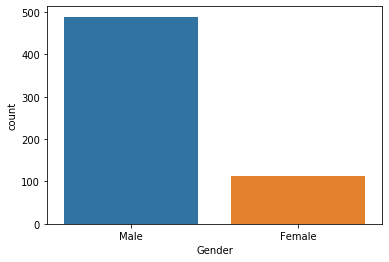

In [385]:
sns.countplot(df_cln0.Gender)

On va donc fixer (Arbitrairement nos valeurs manquante en Female).

In [386]:
df_cln1=df_cln0.copy()
df_cln1["Gender"]=df_cln1.Gender.fillna("Female")
#On rempli nos NaN avec une valeur fixe Female.

In [387]:
df_cln1.Gender.isnull().sum()

0

#### Married
Ici il est plus difficle de statuer car le fait d'être mariée peut renforcer l'aspect de stabilité d'un foyer auprès de l'organisme bancaire. Visualisons dans un premier temps. 

In [388]:
df_cln1.loc[df_cln1['Married'].isnull()]
#On remarque que l'ID 104 a un CoapplicantIncome non null on peut partir du postulat qu'il y a donc une seconde personne 
#Dans le foyer probablement un conjoint. 
#Pour les autres rien.
#On va donc remplacer la ligne 104 par Yes et les 228 et 435 par No

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
104,LP001357,Male,NaN,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
228,LP001760,Male,NaN,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
435,LP002393,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y


In [389]:
#
df_cln1.iloc[104,2]="Yes"
df_cln1.iloc[[228,435],2]="No"

In [390]:
df_cln1.Married.isnull().sum()

0

#### Dépendents

   Le nombre de personne à charge n'est pas évident à deviner car il n'aura a priorie aucun impact direct sur les autres variables. Cependant on peut imaginer une corélation entre le fait d'être marrié et le fait d'avoir des enfants (Même si il existe des exceptions). 

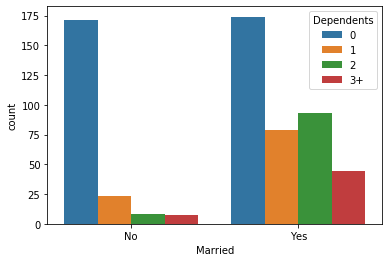

In [391]:
sns.countplot("Married",hue="Dependents", data=df_cln1)
#Effectivement, il y a une forte majorité de 0 personne à charge pour les célibataires. 

In [392]:
df_cln1.loc[df.Dependents.isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
102,LP001350,Male,Yes,NaN,Graduate,No,13650,0.0,NaN,360.0,1.0,Urban,Y
104,LP001357,Male,Yes,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
120,LP001426,Male,Yes,NaN,Graduate,No,5667,2667.0,180.0,360.0,1.0,Rural,Y
226,LP001754,Male,Yes,NaN,Not Graduate,Yes,4735,0.0,138.0,360.0,1.0,Urban,N
228,LP001760,Male,No,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
293,LP001945,Female,No,NaN,Graduate,No,5417,0.0,143.0,480.0,0.0,Urban,N
301,LP001972,Male,Yes,NaN,Not Graduate,No,2875,1750.0,105.0,360.0,1.0,Semiurban,Y
332,LP002100,Male,No,NaN,Graduate,No,2833,0.0,71.0,360.0,1.0,Urban,Y
335,LP002106,Male,Yes,NaN,Graduate,Yes,5503,4490.0,70.0,NaN,1.0,Semiurban,Y
346,LP002130,Male,Yes,NaN,Not Graduate,No,3523,3230.0,152.0,360.0,0.0,Rural,N


In [393]:
df_cln2=df_cln1.copy()

In [394]:
#On modifie déjà nos célibataires avec un 0 en dépendents

In [395]:
df_cln2.Dependents.loc[((df_cln2.Dependents.isnull())&(df_cln2.Married == "No"))]="0"

In [396]:
df_cln2.loc[df_cln2.Dependents.isnull()]
#Il ne nous reste plus que des gens marrié avec un nombre indéterminté de Dependents


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
102,LP001350,Male,Yes,NaN,Graduate,No,13650,0.0,NaN,360.0,1.0,Urban,Y
104,LP001357,Male,Yes,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
120,LP001426,Male,Yes,NaN,Graduate,No,5667,2667.0,180.0,360.0,1.0,Rural,Y
226,LP001754,Male,Yes,NaN,Not Graduate,Yes,4735,0.0,138.0,360.0,1.0,Urban,N
301,LP001972,Male,Yes,NaN,Not Graduate,No,2875,1750.0,105.0,360.0,1.0,Semiurban,Y
335,LP002106,Male,Yes,NaN,Graduate,Yes,5503,4490.0,70.0,NaN,1.0,Semiurban,Y
346,LP002130,Male,Yes,NaN,Not Graduate,No,3523,3230.0,152.0,360.0,0.0,Rural,N
517,LP002682,Male,Yes,NaN,Not Graduate,No,3074,1800.0,123.0,360.0,0.0,Semiurban,N
571,LP002847,Male,Yes,NaN,Graduate,No,5116,1451.0,165.0,360.0,0.0,Urban,N


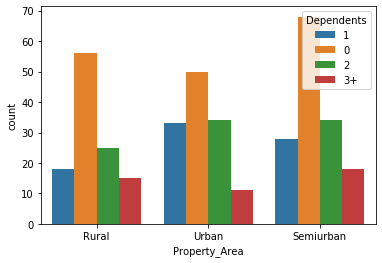

In [397]:
#Partons du postulats que les gens marrié vivant à la campagne sont plus enclin à faire des enfants.
sns.countplot(hue="Dependents", x="Property_Area", data=df_cln2.loc[df_cln2['Married']=="Yes"])
#C'est assez peu concluant.

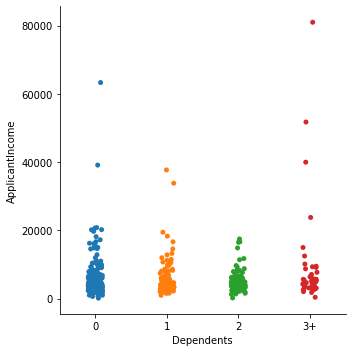

In [398]:
#Un haut revenu est un terreau propice pour des enfants.
sns.catplot(x="Dependents", y="ApplicantIncome", data=df_cln2)

(0, 15000)

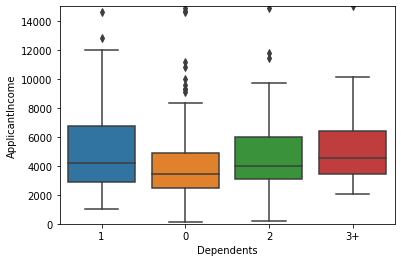

In [399]:
sns.boxplot(x="Dependents",y="ApplicantIncome", data=df_cln2.loc[df_cln2['Married']=="Yes"])
plt.ylim(0,15000)
#Passé 5000 applicantIncome il y a plus de chance d'avoir 1 Dependents. 

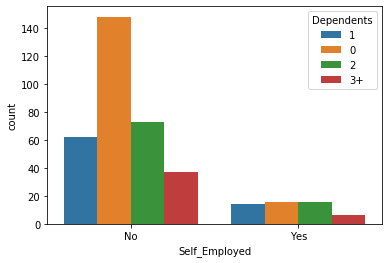

In [400]:
#Un dernier axe serait de vérifier le selfemployement

sns.countplot(hue="Dependents", x="Self_Employed", data=df_cln2.loc[df_cln2['Married']=="Yes"])

On a donc étudié 3 variables en liaison avec le nombre de Dependants nous pouvons poser quelques régle de subtistution. Le plus marquant reste l'income. 
<ul><li>Les clients avec un income supplémentaire de 5000 seront fixé avec un dependants 1</li>
    <li>En dessous de 5000 les clients veront leur dépendants fixé à 0</li>

In [401]:
df_cln2.Dependents.loc[((df_cln2.Dependents.isnull())&(df_cln2.ApplicantIncome >= 5000))]="1"
df_cln2.Dependents.loc[((df_cln2.Dependents.isnull())&(df_cln2.ApplicantIncome <= 5000))]="0"

In [402]:
df_cln2.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

#### Self_Employed
Le status d'auto entrepreneur peut être un frein à l'obtention d'un crédit.
Une écrasante majorité des clients ne le sont pas.

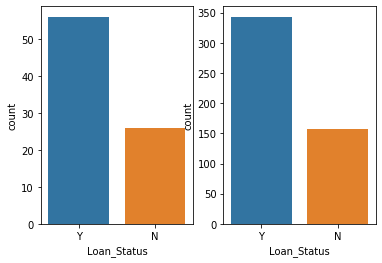

In [403]:

plt.subplot(1,2,1)
sns.countplot("Loan_Status", data=df_cln2.loc[df_cln2['Self_Employed']=="Yes"])

plt.subplot(1,2,2)
sns.countplot("Loan_Status", data=df_cln2.loc[df_cln2['Self_Employed']=="No"])


In [404]:
# Le graphique ci-dessus montre une certaine indépendance de cette variable.  

In [405]:
df_cln2.loc[df_cln2['Self_Employed']=="No"].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,500.00000,500.000000,482.000000,489.000000,463.000000
mean,5049.74800,1580.989840,141.748963,343.263804,0.835853
std,5682.89581,2438.161181,79.780919,64.696881,0.370809
min,150.00000,0.000000,9.000000,12.000000,0.000000
25%,2824.50000,0.000000,100.000000,360.000000,1.000000
50%,3705.50000,1293.500000,125.000000,360.000000,1.000000
75%,5292.75000,2303.000000,161.750000,360.000000,1.000000
max,81000.00000,33837.000000,700.000000,480.000000,1.000000


In [406]:
df_cln2.loc[df_cln2['Self_Employed']=="Yes"].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,82.000000,82.000000,79.00000,80.00000,75.000000
mean,7380.817073,1501.341463,172.00000,336.30000,0.840000
std,5883.564795,2780.713676,108.63465,69.39529,0.369075
min,674.000000,0.000000,25.00000,60.00000,0.000000
25%,3452.250000,0.000000,106.00000,360.00000,1.000000
50%,5809.000000,0.000000,150.00000,360.00000,1.000000
75%,9348.500000,2164.500000,189.00000,360.00000,1.000000
max,39147.000000,20000.000000,650.00000,480.00000,1.000000


In [407]:
#On remarque une moyenne d'income des Self_employed plus élevé que pour le client classique.
#Cependant le max des clients classique monte plus haut et le min descent plus bas

In [408]:
df_cln2.loc[df_cln2['Self_Employed'].isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
11,LP001027,Male,Yes,2,Graduate,NaN,2500,1840.0,109.0,360.0,1.0,Urban,Y
19,LP001041,Male,Yes,0,Graduate,NaN,2600,3500.0,115.0,NaN,1.0,Urban,Y
24,LP001052,Male,Yes,1,Graduate,NaN,3717,2925.0,151.0,360.0,NaN,Semiurban,N
29,LP001087,Female,No,2,Graduate,NaN,3750,2083.0,120.0,360.0,1.0,Semiurban,Y
30,LP001091,Male,Yes,1,Graduate,NaN,4166,3369.0,201.0,360.0,NaN,Urban,N
95,LP001326,Male,No,0,Graduate,NaN,6782,0.0,NaN,360.0,NaN,Urban,N
107,LP001370,Male,No,0,Not Graduate,NaN,7333,0.0,120.0,360.0,1.0,Rural,N
111,LP001387,Female,Yes,0,Graduate,NaN,2929,2333.0,139.0,360.0,1.0,Semiurban,Y
114,LP001398,Male,No,0,Graduate,NaN,5050,0.0,118.0,360.0,1.0,Semiurban,Y
158,LP001546,Male,No,0,Graduate,NaN,2980,2083.0,120.0,360.0,1.0,Rural,Y


On va partir de ce postulat: 
   <ul><li>Au delà de 4000 on va fixer notre client en Yes</li>
    <li>En dessous il sera en No</li></ul>

In [409]:
df_cln3=df_cln2.copy()

In [410]:
df_cln3.Self_Employed.loc[(df_cln3.Self_Employed.isnull())&(df_cln2.ApplicantIncome >= 4000)]="Yes"
df_cln3.Self_Employed.loc[(df_cln3.Self_Employed.isnull())&(df_cln2.ApplicantIncome <= 4000)]="No"

#### Credit History

Encore une fois il est difficile de deviner si un client a déjà eu un crédit. On peut imaginer que de très bas revenu n'y ont jamais eu accès

(0, 10000)

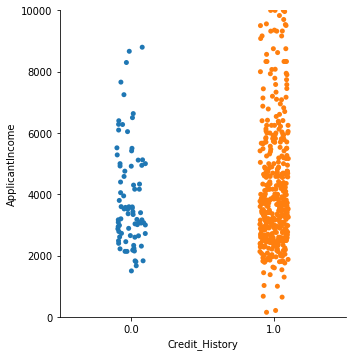

In [411]:
sns.catplot(y="ApplicantIncome", x="Credit_History", data=df_cln3)
plt.ylim(0,10000)

In [412]:
df_cln3.loc[df_cln3.Credit_History == 1].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,475.000000,475.000000,458.000000,467.000000,475.0
mean,5426.526316,1528.250358,144.786026,342.192719,1.0
std,5535.393384,2548.728908,83.051842,64.268660,0.0
min,150.000000,0.000000,9.000000,36.000000,1.0
25%,2908.500000,0.000000,100.000000,360.000000,1.0
50%,3859.000000,1040.000000,128.000000,360.000000,1.0
75%,5820.000000,2241.000000,168.000000,360.000000,1.0
max,63337.000000,33837.000000,700.000000,480.000000,1.0


In [413]:
df_cln3.loc[df_cln3.Credit_History == 0].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,89.000000,89.000000,85.000000,83.000000,89.0
mean,5679.438202,1542.179775,146.717647,341.927711,0.0
std,9301.896041,2023.914617,85.164772,66.744102,0.0
min,1500.000000,0.000000,45.000000,180.000000,0.0
25%,2787.000000,0.000000,104.000000,360.000000,0.0
50%,3547.000000,1330.000000,125.000000,360.000000,0.0
75%,5285.000000,2254.000000,160.000000,360.000000,0.0
max,81000.000000,11300.000000,600.000000,480.000000,0.0


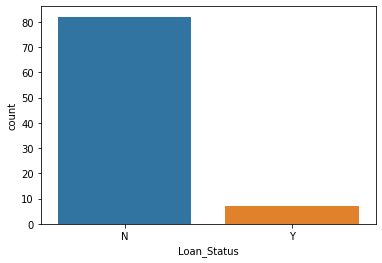

In [414]:
sns.countplot("Loan_Status", data=df_cln3.loc[df_cln3.Credit_History == 0])
#Une majorité écrasante de Credit_History  0 ce voient refusé un nouveau crédit.

On va donc partir sur ce postulat si Loan_Status est égale à N alors Credit_History est égale à 0 et vis versa

In [415]:
df_cln4=df_cln3.copy()

In [416]:
df_cln4.Credit_History.loc[(df_cln4.Credit_History.isnull())&(df_cln4.Loan_Status== "N")]= 0
df_cln4.Credit_History.loc[(df_cln4.Credit_History.isnull())&(df_cln4.Loan_Status== "Y")]= 1

In [417]:
df_cln4.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

### <a id="7">Variable quantitative</a>

#### LoanAmount
Voyons déjà si il n'y aurait pas un lien entre nos deux variable lié au prêt.
On peut imaginer que les mensualité sont directement lié au montant total du prêt (Il nous manque cependant les mensualités.

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

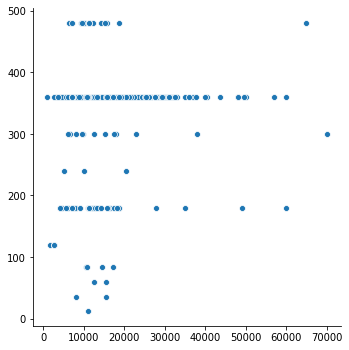

In [418]:
sns.relplot(x=df_cln4.LoanAmount*100, y="Loan_Amount_Term", data=df_cln4)

In [419]:
df_cln4.Loan_Amount_Term.unique()

array([360., 120., 240.,  nan, 180.,  60., 300., 480.,  36.,  84.,  12.])

In [420]:
df_cln4.loc[df_cln4["LoanAmount"].isnull()]
#Nombre des Loan_Amount_Term sont égaux à 360

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
35,LP001106,Male,Yes,0,Graduate,No,2275,2067.0,NaN,360.0,1.0,Urban,Y
63,LP001213,Male,Yes,1,Graduate,No,4945,0.0,NaN,360.0,0.0,Rural,N
81,LP001266,Male,Yes,1,Graduate,Yes,2395,0.0,NaN,360.0,1.0,Semiurban,Y
95,LP001326,Male,No,0,Graduate,Yes,6782,0.0,NaN,360.0,0.0,Urban,N
102,LP001350,Male,Yes,1,Graduate,No,13650,0.0,NaN,360.0,1.0,Urban,Y
103,LP001356,Male,Yes,0,Graduate,No,4652,3583.0,NaN,360.0,1.0,Semiurban,Y
113,LP001392,Female,No,1,Graduate,Yes,7451,0.0,NaN,360.0,1.0,Semiurban,Y
127,LP001449,Male,No,0,Graduate,No,3865,1640.0,NaN,360.0,1.0,Rural,Y
202,LP001682,Male,Yes,3+,Not Graduate,No,3992,0.0,NaN,180.0,1.0,Urban,N


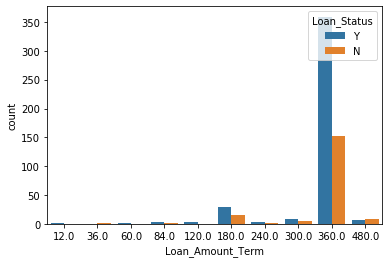

In [421]:
sns.countplot("Loan_Amount_Term",hue="Loan_Status",data=df_cln4)
#La donnée à 360 pour le Loan_Amount_Term est grandement majoritaire.

In [422]:
df_cln4.loc[(df_cln4.Loan_Amount_Term == 360) & (df_cln4.Loan_Status=="Y")].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,359.000000,359.000000,349.000000,359.0,359.000000
mean,5053.649025,1503.808134,142.593123,360.0,0.986072
std,4283.888488,1902.564141,73.065634,0.0,0.117354
min,210.000000,0.000000,26.000000,360.0,0.000000
25%,2816.000000,0.000000,101.000000,360.0,1.000000
50%,3750.000000,1387.000000,128.000000,360.0,1.000000
75%,5686.000000,2264.000000,161.000000,360.0,1.000000
max,39147.000000,20000.000000,600.000000,360.0,1.000000


In [423]:
df_cln4.loc[(df_cln4.Loan_Amount_Term == 360) & (df_cln4.Loan_Status=="N")].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,153.000000,153.000000,144.000000,153.0,153.000000
mean,5871.627451,1699.405229,158.520833,360.0,0.522876
std,7524.175897,3596.502011,90.835513,0.0,0.501117
min,150.000000,0.000000,9.000000,360.0,0.000000
25%,3036.000000,0.000000,104.000000,360.0,0.000000
50%,4166.000000,0.000000,133.500000,360.0,1.000000
75%,6080.000000,2210.000000,185.000000,360.0,1.000000
max,81000.000000,33837.000000,570.000000,360.0,1.000000


In [424]:
df_cln5=df_cln4.copy()

In [425]:
#Ici on remplace les valeurs Nan de ApplicantIncome par la mediane (Arrondie)
# des samples avec un Loan_Amount_Term égale à 360 et appartenant à la target N et Y
df_cln5.LoanAmount.loc[(df_cln5.LoanAmount.isnull()) & (df_cln5.Loan_Amount_Term == 360) & (df_cln4.Loan_Status=="Y")]= round(df_cln4.ApplicantIncome.loc[(df_cln5.Loan_Amount_Term == 360) & (df_cln5.Loan_Status=="Y")].median(),0)
df_cln5.LoanAmount.loc[(df_cln5.LoanAmount.isnull()) & (df_cln5.Loan_Amount_Term == 360) & (df_cln4.Loan_Status=="N")]= round(df_cln4.ApplicantIncome.loc[(df_cln5.Loan_Amount_Term == 360) & (df_cln5.Loan_Status=="N")].median(),0)

In [426]:
c= df_cln4.columns
c[0]
z= range(0,len(c)-1)

for x,z in zip(c,z):
    print(c[z],len(df_cln4[x].unique()))

Loan_ID 614
Gender 2
Married 2
Dependents 4
Education 2
Self_Employed 2
ApplicantIncome 505
CoapplicantIncome 287
LoanAmount 204
Loan_Amount_Term 11
Credit_History 2
Property_Area 3


In [427]:
round(df_cln4.loc[(df_cln5.Loan_Amount_Term == 360) & (df_cln5.Loan_Status=="Y")].median(),0)

ApplicantIncome      3750.0
CoapplicantIncome    1387.0
LoanAmount            128.0
Loan_Amount_Term      360.0
Credit_History          1.0
dtype: float64

In [428]:
df_cln5.loc[df_cln5.LoanAmount.isnull()]
#Faisons de même avec les 180 et 240 !

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
202,LP001682,Male,Yes,3+,Not Graduate,No,3992,0.0,NaN,180.0,1.0,Urban,N
435,LP002393,Female,No,0,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y
605,LP002960,Male,Yes,0,Not Graduate,No,2400,3800.0,NaN,180.0,1.0,Urban,N


In [429]:
df_cln5.LoanAmount.loc[(df_cln5.LoanAmount.isnull()) & (df_cln5.Loan_Amount_Term == 240) & (df_cln5.Loan_Status=="Y")]= round(df_cln5.ApplicantIncome.loc[(df_cln5.Loan_Amount_Term == 240) & (df_cln5.Loan_Status=="Y")].median(),0)
df_cln5.LoanAmount.loc[(df_cln5.LoanAmount.isnull()) & (df_cln5.Loan_Amount_Term == 240) & (df_cln5.Loan_Status=="N")]= round(df_cln5.ApplicantIncome.loc[(df_cln5.Loan_Amount_Term == 240) & (df_cln5.Loan_Status=="N")].median(),0)

In [430]:
df_cln5.loc[df_cln5.LoanAmount.isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
202,LP001682,Male,Yes,3+,Not Graduate,No,3992,0.0,NaN,180.0,1.0,Urban,N
605,LP002960,Male,Yes,0,Not Graduate,No,2400,3800.0,NaN,180.0,1.0,Urban,N


In [431]:
df_cln5.LoanAmount.loc[(df_cln5.LoanAmount.isnull()) & (df_cln5.Loan_Amount_Term == 180) & (df_cln5.Loan_Status=="Y")]= round(df_cln5.ApplicantIncome.loc[(df_cln5.Loan_Amount_Term == 180) & (df_cln5.Loan_Status=="Y")].median(),0)
df_cln5.LoanAmount.loc[(df_cln5.LoanAmount.isnull()) & (df_cln5.Loan_Amount_Term == 180) & (df_cln5.Loan_Status=="N")]= round(df_cln5.ApplicantIncome.loc[(df_cln5.Loan_Amount_Term == 180) & (df_cln5.Loan_Status=="N")].median(),0)

In [432]:
df_cln5.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

#### Loan_Amount_Term

On pourrait imaginer faire pareille quand dans le cas précédents cependant ici le LoanAmount a beaucoup plus de valeurs différentes. On va plutôt réfléchir à remplacer tout nos NaN par ce qui est a la fois le mode et la median de notre colonne Loan_Amount_Term soit 360

In [433]:
df_cln5.loc[df_cln5.Loan_Amount_Term.isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
19,LP001041,Male,Yes,0,Graduate,No,2600,3500.0,115.0,NaN,1.0,Urban,Y
36,LP001109,Male,Yes,0,Graduate,No,1828,1330.0,100.0,NaN,0.0,Urban,N
44,LP001136,Male,Yes,0,Not Graduate,Yes,4695,0.0,96.0,NaN,1.0,Urban,Y
45,LP001137,Female,No,0,Graduate,No,3410,0.0,88.0,NaN,1.0,Urban,Y
73,LP001250,Male,Yes,3+,Not Graduate,No,4755,0.0,95.0,NaN,0.0,Semiurban,N
112,LP001391,Male,Yes,0,Not Graduate,No,3572,4114.0,152.0,NaN,0.0,Rural,N
165,LP001574,Male,Yes,0,Graduate,No,3707,3166.0,182.0,NaN,1.0,Rural,Y
197,LP001669,Female,No,0,Not Graduate,No,1907,2365.0,120.0,NaN,1.0,Urban,Y
223,LP001749,Male,Yes,0,Graduate,No,7578,1010.0,175.0,NaN,1.0,Semiurban,Y
232,LP001770,Male,No,0,Not Graduate,No,3189,2598.0,120.0,NaN,1.0,Rural,Y


In [434]:
df_cln5.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,600.00000,614.000000
mean,5403.459283,1621.245798,279.400651,342.00000,0.833876
std,6109.041673,2926.248369,698.619746,65.12041,0.372495
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.250000,360.00000,1.000000
50%,3812.500000,1188.500000,129.000000,360.00000,1.000000
75%,5795.000000,2297.250000,175.000000,360.00000,1.000000
max,81000.000000,41667.000000,4166.000000,480.00000,1.000000


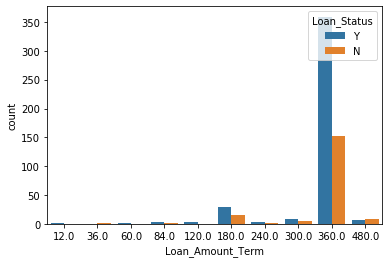

In [435]:
sns.countplot("Loan_Amount_Term", hue="Loan_Status", data=df_cln5)
#On peut vraiment voir l'écrasante domination du Loan_Amount_Term à 360

In [436]:
df_cln6=df_cln5.copy()

In [437]:
df_cln6.Loan_Amount_Term.loc[df_cln6.Loan_Amount_Term.isnull()]= 360

In [438]:
df_cln6.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

#### Conclusion
Nos données sont maintenant totalement rempli avec nos nouvelles valeurs explorons maintenant les type de nos variables. 

### <a id='8'><center><font color="INDIANRED">6) Nettoyage des données - Modification types des données</font></center></a>

Ici on peut imaginer changer certaine de nos données: 
<ul><li>Changer les variables discréte en numérique pour être sure qu'elle soit accepté par nos algorithme</li>
    <li>Générer peut-être une colonne par résultat catégorical (Exemple: Male 0 ou 1 / Female 0 ou 1)</li>
    <li>Restituer leur forme inital aux donnée (LoanAmount x 100)</li>
    <li>Vérifier que les types sont cohérents</li></ul>

In [439]:
df_cln6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


### <a id="9">Gestion des variables categorical</a>

#### One Hot encoder

La bibliothéques One Hot encoder permet de généré des colonnes pour stocker toutes les possibilités d'une variable qualitatif au format booléen (Je suis encore en recherche sur cette fonction étant donné que c'est ma première tentative avec.

In [440]:
ohe= OneHotEncoder()

In [441]:
df_cln7= df_cln6.copy()

In [442]:
ohe.fit(df_cln7)

OneHotEncoder()

In [443]:
df_cln8=ohe.transform(df_cln7)

In [444]:
df_cln7

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,3750.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [445]:
le=LabelEncoder()

In [446]:
integer_encoded = le.fit_transform(df_cln7["Married"])

In [447]:
integer_encoded.shape

(614,)

In [448]:
#On boucle sur notre LabelEncoder qui permet de remplacer nos catégorie par des numéros.
df_cln8=df_cln7.copy()
for n in df_cln8.iloc[:,1:].select_dtypes('object').columns :
    df_cln8[n]=le.fit_transform(y=df_cln8[n])
    

In [449]:
df_cln8
#Plus de string que des chiffre (Ce que nous souhaitions)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,0,0,5849,0.0,3750.0,360.0,1.0,2,1
1,LP001003,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,LP001005,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,LP001006,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,LP001008,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,0,0,0,0,0,2900,0.0,71.0,360.0,1.0,0,1
610,LP002979,1,1,3,0,0,4106,0.0,40.0,180.0,1.0,0,1
611,LP002983,1,1,1,0,0,8072,240.0,253.0,360.0,1.0,2,1
612,LP002984,1,1,2,0,0,7583,0.0,187.0,360.0,1.0,2,1


In [450]:
#Maintenant on va séparer nos colonnes catégorie en n colonnes booléene 
ohe= OneHotEncoder(sparse=False)

In [451]:
#Déjà avec la colonne Gender pour comprendre le fonctionnement pas à pas. 
ohe= OneHotEncoder(sparse=True)
integer_encoded= df_cln8[["Gender"]]
X= ohe.fit_transform(integer_encoded)

In [452]:
X

<614x2 sparse matrix of type '<class 'numpy.float64'>'
	with 614 stored elements in Compressed Sparse Row format>

In [453]:
df_cln8[["Female","Male"]]= X

KeyError: "None of [Index(['Female', 'Male'], dtype='object')] are in the [columns]"

In [459]:
df_cln8.sum()

Loan_ID              LP001002LP001003LP001005LP001006LP001008LP0010...
Gender                                                             489
Married                                                            399
Dependents                                                         461
Education                                                          134
Self_Employed                                                       94
ApplicantIncome                                                3317724
CoapplicantIncome                                               995445
LoanAmount                                                      171552
Loan_Amount_Term                                                210240
Credit_History                                                     512
Property_Area                                                      637
Loan_Status                                                        422
dtype: object

#Essayons de gagner du temps en implémentant nos données en block. 
indexC = [2,3,4,5,10,11] #Nos colonnes catégorical (Hors target)
X2,X3,X4,X5,X10,X11= ohe.fit_transform(df_cln8.iloc[:,indexC])
X2= ohe.fit_transform(df_cln8.iloc[:,indexC])
print(X2[:,1])
#ça n'a pas fonctionné comme je l'espérais je n'arrive pas a traiter les données tel qu'elle me sont renvoyé ici je vais
#donc fonctionner features par feature mais en créant une fonction

In [460]:
def encoder_multi(df,colname):
    ohe= OneHotEncoder(sparse=False)
    integer_encoded= df[[colname]]
    X= ohe.fit_transform(integer_encoded)
    return X

#### Notes
Je tatonne encore avec la fonction OneHotEncoder je vais donc comparé de visuel les 10 première ligne de mes résultats
Avec le df en question non modifé et je note les correspondances.

In [461]:
#Notre DF_cln7 ou les catégorie n'ont pas encore été modifié.
df_cln7[:10]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,3750.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


#### Married

Mx= encoder_multi(df_cln8,"Married")

In [462]:
Mx[:10] #Not_married / Married

NameError: name 'Mx' is not defined

##### Dependants

In [463]:
Dpx= encoder_multi(df_cln8,"Dependents")

In [464]:
Dpx[:10] # 0, 1, 2, 3+

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]])

####  Education

In [465]:
Edux= encoder_multi(df_cln8,"Education")

In [466]:
Edux[:10] #Graduate / Not Graduate

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

#### Self Employement

In [467]:
Selx= encoder_multi(df_cln8,"Self_Employed")

In [468]:
Selx[:10] #No / Yes

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

#### Property_Area

In [469]:
Locx= encoder_multi(df_cln8,"Property_Area")

In [470]:
Locx[:10] #Rural / Semiurban / Urban

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [471]:
Histx= encoder_multi(df_cln8,"Credit_History")

In [472]:
Histx[:10] #Never_Credit, Already_Credit

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

#### Notes

Il semblerait que les catégorie sont classé de manière croissante et alphabétique. 

In [473]:
df_cln9= df_cln8.copy()

In [474]:
df_cln9[["Not_Married","Married_"]]= Mx
df_cln9[["0_dep","1_dep","2_dep","3m_dep"]]= Dpx
df_cln9[["Graduate","Not_Graduate"]]= Edux

df_cln9[["Employed_","Self_Employed_"]]= Selx
df_cln9[["Rural","SemiUrban","Urban"]]= Locx
df_cln9[['Never_Credit',"Already_Credit"]]=Histx

NameError: name 'Mx' is not defined

In [475]:
df_cln9["Loan_Status"]

0      1
1      0
2      1
3      1
4      1
      ..
609    1
610    1
611    1
612    1
613    0
Name: Loan_Status, Length: 614, dtype: int32

In [476]:
df_cln10=df_cln9.copy()

On peut maintenant Drop nos anciennes colonnes.

In [477]:
df_cln10.drop(df_cln10.columns[[1,2,3,4,5,10,11]], axis=1, inplace=True)

In [478]:
df_cln10

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status
0,LP001002,5849,0.0,3750.0,360.0,1
1,LP001003,4583,1508.0,128.0,360.0,0
2,LP001005,3000,0.0,66.0,360.0,1
3,LP001006,2583,2358.0,120.0,360.0,1
4,LP001008,6000,0.0,141.0,360.0,1
...,...,...,...,...,...,...
609,LP002978,2900,0.0,71.0,360.0,1
610,LP002979,4106,0.0,40.0,180.0,1
611,LP002983,8072,240.0,253.0,360.0,1
612,LP002984,7583,0.0,187.0,360.0,1


Je vais maintenant sauvegardé trois dataframes dans trois nouvelle variable, <b>df_cleaned</b>, <b>df_catnum</b>  et <b>df_encoded</b> me permettant de faire un test sur l'effet des changements que j'ai effectué au fil du procédé en étape 7 8 et 10 du nétoyage.

In [479]:
df_cleaned = df_cln7.copy()
df_catnum = df_cln8.copy()
df_encoded= df_cln10.copy()

### <a id='10'><center><font color="INDIANRED">8) Gestion des outliers </font></center></a>

Nous avons quatres variable numériques qui peuvent contenir de potentiel outlier : Applicant_Income, CoapplicantIncome, LoanAmount et Loan_Amount_Term.

### Traitement général

In [480]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   ApplicantIncome    614 non-null    int64  
 2   CoapplicantIncome  614 non-null    float64
 3   LoanAmount         614 non-null    float64
 4   Loan_Amount_Term   614 non-null    float64
 5   Loan_Status        614 non-null    int32  
dtypes: float64(3), int32(1), int64(1), object(1)
memory usage: 26.5+ KB


In [481]:
df_encoded.iloc[:,1:5].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,279.400651,342.410423
std,6109.041673,2926.248369,698.619746,64.428629
min,150.000000,0.000000,9.000000,12.000000
25%,2877.500000,0.000000,100.250000,360.000000
50%,3812.500000,1188.500000,129.000000,360.000000
75%,5795.000000,2297.250000,175.000000,360.000000
max,81000.000000,41667.000000,4166.000000,480.000000


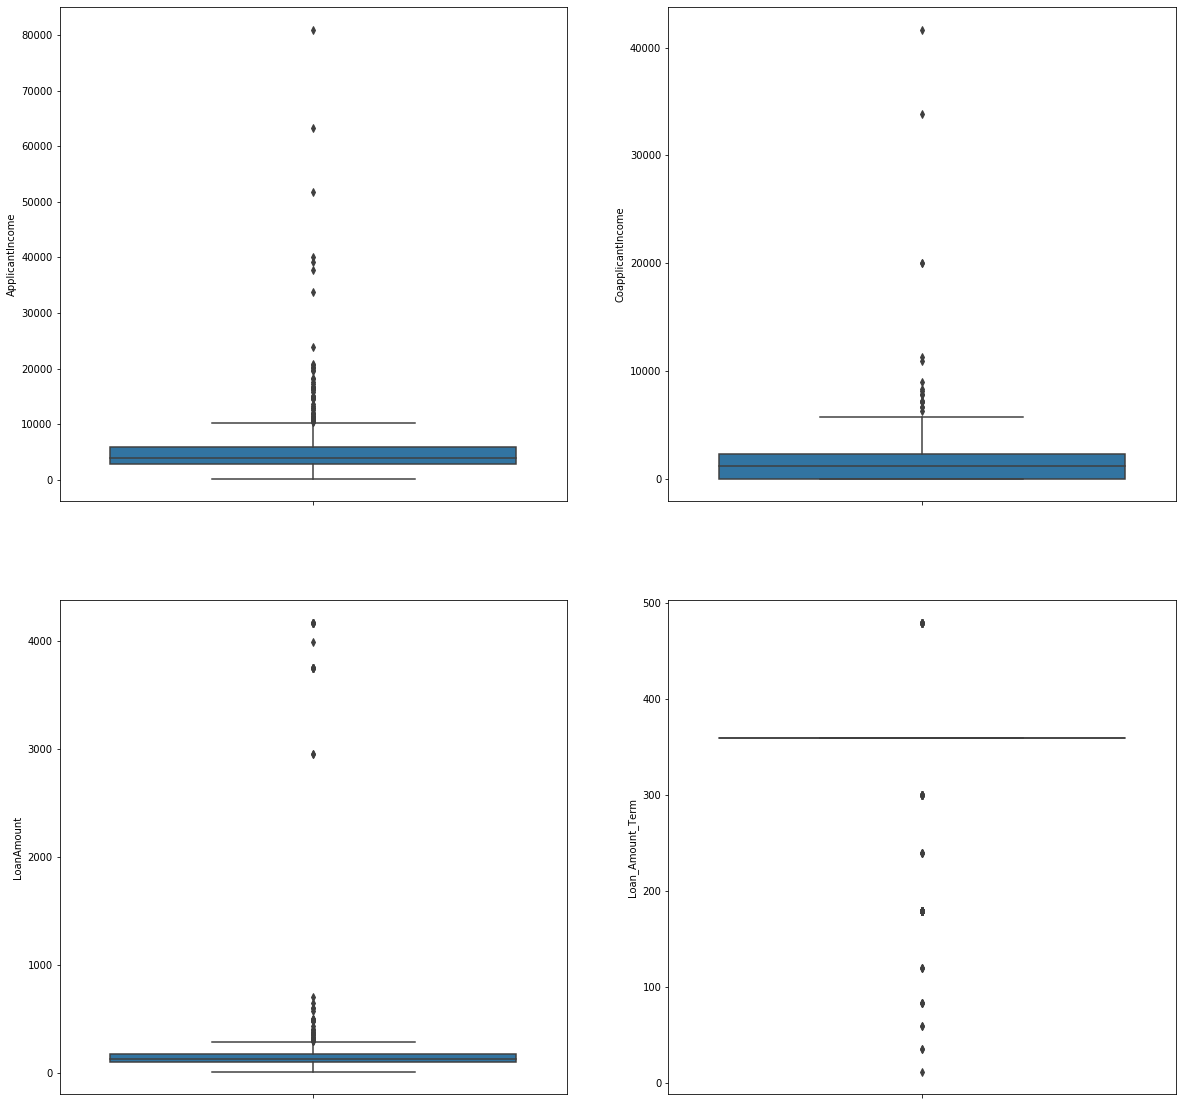

In [482]:
col=range(1,5)
n=1
plt.figure(figsize=(20,20))
for x in col:
    
    plt.subplot(2,2,n)
    sns.boxplot(y= df_encoded.iloc[:,x])
    n=n+1

In [483]:
df_encoded.loc[df_encoded.Loan_Amount_Term != 360.0]

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status
14,LP001030,1299,1086.0,17.0,120.0,1
16,LP001034,3596,0.0,100.0,240.0,1
62,LP001207,2609,3449.0,165.0,180.0,0
66,LP001228,3200,2254.0,126.0,180.0,0
68,LP001238,7100,0.0,125.0,60.0,1
...,...,...,...,...,...,...
591,LP002931,6000,0.0,205.0,240.0,0
593,LP002936,3859,3300.0,142.0,180.0,1
600,LP002949,416,41667.0,350.0,180.0,0
605,LP002960,2400,3800.0,2947.0,180.0,0


In [484]:
df_encoded.loc[df_encoded.LoanAmount >2000]

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status
0,LP001002,5849,0.0,3750.0,360.0,1
35,LP001106,2275,2067.0,3750.0,360.0,1
63,LP001213,4945,0.0,4166.0,360.0,0
81,LP001266,2395,0.0,3750.0,360.0,1
95,LP001326,6782,0.0,4166.0,360.0,0
102,LP001350,13650,0.0,3750.0,360.0,1
103,LP001356,4652,3583.0,3750.0,360.0,1
113,LP001392,7451,0.0,3750.0,360.0,1
127,LP001449,3865,1640.0,3750.0,360.0,1
202,LP001682,3992,0.0,2947.0,180.0,0


In [485]:
df_encoded.loc[df_encoded.ApplicantIncome > 40000]

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status
171,LP001585,51763,0.0,700.0,300.0,1
333,LP002101,63337,0.0,490.0,180.0,1
409,LP002317,81000,0.0,360.0,360.0,0


In [486]:
df_encoded.loc[df_encoded.CoapplicantIncome > 20000]

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status
581,LP002893,1836,33837.0,90.0,360.0,0
600,LP002949,416,41667.0,350.0,180.0,0


In [487]:
df_encoded["Loan_Amount_Term"].value_counts()

360.0    526
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [488]:
df_encoded.sort_values("Loan_Amount_Term")

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status
497,LP002588,4625,2857.0,111.0,12.0,1
546,LP002768,3358,0.0,80.0,36.0,0
262,LP001870,3481,0.0,155.0,36.0,0
68,LP001238,7100,0.0,125.0,60.0,1
242,LP001806,2965,5701.0,155.0,60.0,1
...,...,...,...,...,...,...
358,LP002158,3000,1666.0,100.0,480.0,0
366,LP002187,2500,0.0,96.0,480.0,0
573,LP002862,6125,1625.0,187.0,480.0,0
228,LP001760,4758,0.0,158.0,480.0,1


On remarque quelques valeurs un peu extrême dans ces 4 features mais rien d'abhérent à ce niveau la de notre compréhension de la dataset il ne serait pas étonnant. Je pourrais uniquement modifié une valeur car il semble qu'il y ait une faute de frappe (Il est peu probable qu'un Income de 80k plus ce voit refuser un emprunt).

### Changement d'échelle

Le LoanAmount a été fait en centaine je vais donc multiplier cette valeur par 100 pour pouvoir appliqué des calculs par la suite. (Je reviendrais peut-être sur mes pas plus tard).

In [489]:
df_encoded['LoanAmount']=df_encoded['LoanAmount']*100
df_cleaned['LoanAmount']=df_cleaned['LoanAmount']*100
df_catnum['LoanAmount']=df_catnum['LoanAmount']*100

In [490]:
df_encoded

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status
0,LP001002,5849,0.0,375000.0,360.0,1
1,LP001003,4583,1508.0,12800.0,360.0,0
2,LP001005,3000,0.0,6600.0,360.0,1
3,LP001006,2583,2358.0,12000.0,360.0,1
4,LP001008,6000,0.0,14100.0,360.0,1
...,...,...,...,...,...,...
609,LP002978,2900,0.0,7100.0,360.0,1
610,LP002979,4106,0.0,4000.0,180.0,1
611,LP002983,8072,240.0,25300.0,360.0,1
612,LP002984,7583,0.0,18700.0,360.0,1


### <a id='11'><center><font color="INDIANRED">8)Seconde Visualisation</font></center></a>

## Seconde Visualisation (Corrélation, Equilibre...)

### <a id="12"> Variable Qualitatif et Target </a>

In [491]:
df_cleaned

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,375000.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,12800.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,6600.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,12000.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,14100.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,7100.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,4000.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,25300.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,18700.0,360.0,1.0,Urban,Y


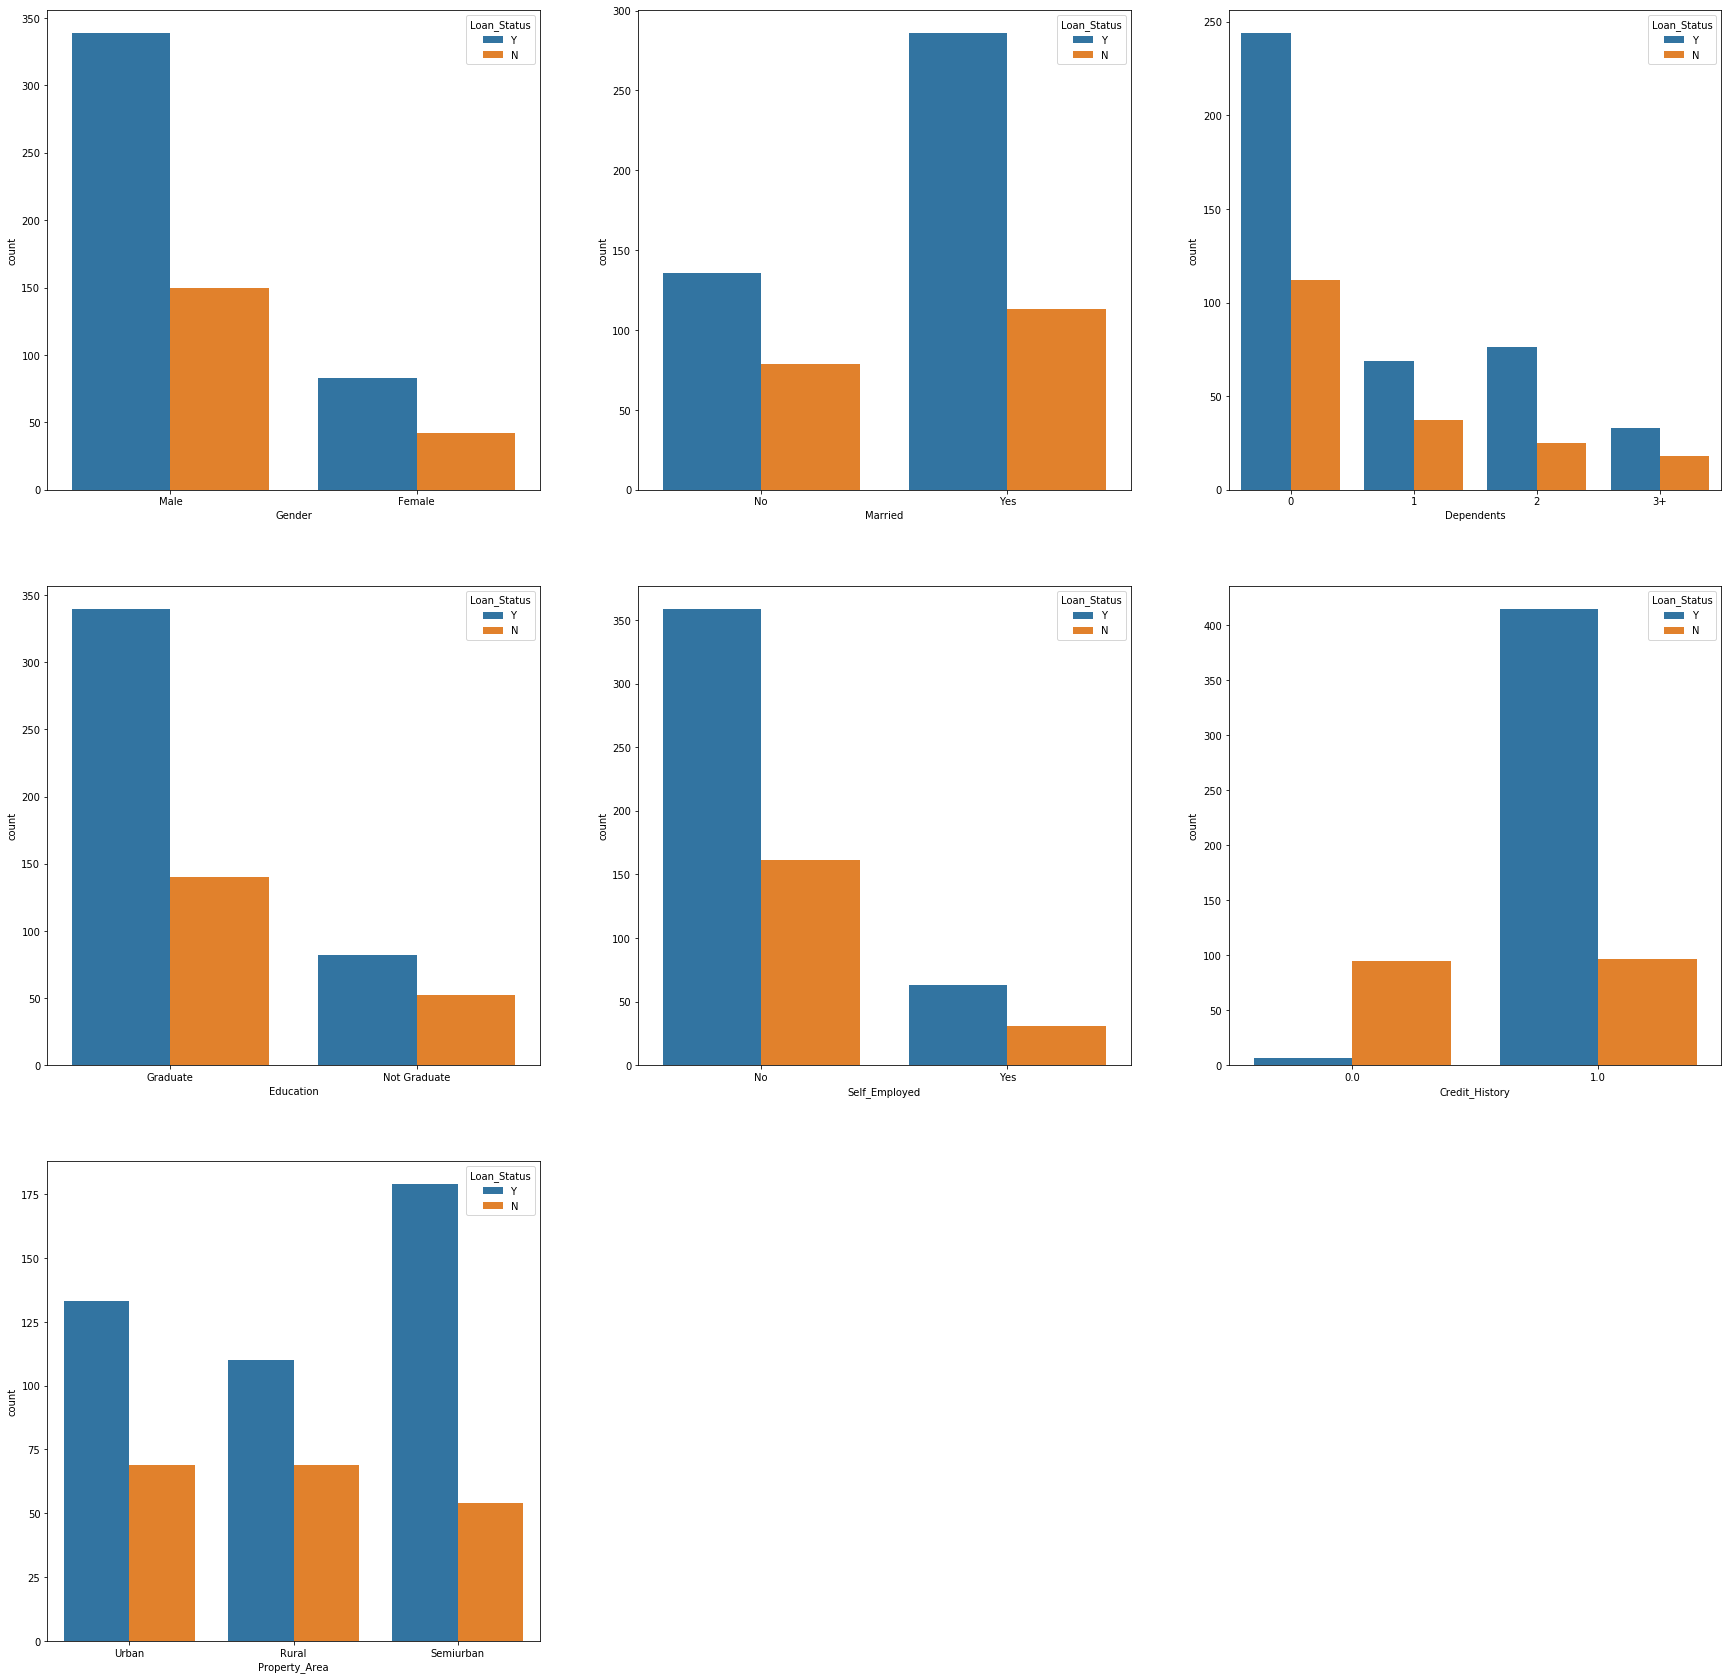

In [492]:
col= [1,2,3,4,5,10,11]
n=1
plt.figure(figsize=[30,30])
for i in col:
    plt.subplot(3,3,n)
    sns.countplot(df_cleaned.iloc[:,i], hue=df_cleaned.iloc[:,12])
    n=n+1
    

Sur le graphique ci-dessus on peut remarquer plusieurs déséquilibres surtout marquantes sur le Credit_History voyont les proportion.

In [493]:
col= [1,2,3,4,5,10,11]
for i in col:
    print("-----
          ")
    kol=df_cleaned.iloc[:,i].unique()
    print(df_cleaned.columns[i],":")
    print("-----")
    for n in kol:
        print(n)
        print("Prêt Accordé",df_cleaned["Loan_Status"].loc[(df_cleaned["Loan_Status"]=="Y")&(df_cleaned.iloc[:,i] == n)].count()/len(df_cleaned["Loan_Status"].loc[df_cleaned.iloc[:,i] == n]))
        print("Prêt Refusé",df_cleaned["Loan_Status"].loc[(df_cleaned["Loan_Status"]=="N")&(df_cleaned.iloc[:,i] == n)].count()/len(df_cleaned["Loan_Status"].loc[df_cleaned.iloc[:,i] == n]))
        print("-----")
        

SyntaxError: EOL while scanning string literal (<ipython-input-493-349a61e848b4>, line 3)

In [ ]:
col= [1,2,3,4,5,10,11]
m=1
ind=["Y","N"]
width=0.6
plt.figure(figsize=[30,30])
for i in col:

    kol=df_cleaned.iloc[:,i].unique()
    plt.suptitle=(df_cleaned.columns[i])   
    for n in kol:
        temp=[]
        plt.subplot(6,3,m)
        temp.append(df_cleaned["Loan_Status"].loc[(df_cleaned["Loan_Status"]=="Y")&(df_cleaned.iloc[:,i] == n)].count()/len(df_cleaned["Loan_Status"].loc[df_cleaned.iloc[:,i] == n]))  
        temp.append(df_cleaned["Loan_Status"].loc[(df_cleaned["Loan_Status"]=="N")&(df_cleaned.iloc[:,i] == n)].count()/len(df_cleaned["Loan_Status"].loc[df_cleaned.iloc[:,i] == n]))
        plt.bar(ind, temp, width, color=('Blue','Red'))
        plt.title("Obtention des prêts pour les "+str(n)+" "+str(round(temp[0]*100))+"%")
        m=m+1

In [ ]:
occ= (df_cleaned['Loan_Status']
      .value_counts(normalize=True)
      .rename('percents')
      .reset_index())
p= sns.barplot(x="index", y="percents", data=occ)

In [ ]:
n=1
plt.figure(figsize=(30,30))
for i in col: 
    occ2=(df_cleaned.groupby([df_cleaned.columns[i]])['Loan_Status']
      .value_counts(normalize=True)
      .rename('percentage')
      .mul(100)
      .reset_index())
    plt.subplot(3,3,n)
    sns.barplot(x="Loan_Status", y="percentage", hue=df_cleaned.columns[i], data=occ2)
    plt.title("Obtention d'un prêt en fonction de : "+ df_cleaned.columns[i] ) 
    n=n+1


#### Conclusion

On remarque que certaine variable ont un gros impact de certaines variables qualitatives sur l'attribution d'un emprunt ou non. 

Le Credit_history a un grand impact sur l'attribution d'un emprunt car cette variable représente les emprunts remboursé en temps et en heure. Un défaut de paiement lors d'un précédent emprunt(0) est presque systématiquement synonime de refus de paiement.

Les différentes famille type (Dependents) ont le même taux d'attribution de crédit mise à part les familles de 2 enfants ont apparement un % d'attribution supérieur aux autres.

Pareillement pour l'endroit de l'habitation semble impacter légérement l'attribution d'un prêt. On peut penser que les gens habitant en banlieu (Des quartiers habituellement plus chère) ont plus facilement accès à un emprunt.

Le fait d'être Self_employed et un homme ou une femme ne semble pas avoir d'impact. 

Enfin pour Education et Married un personne éduqué et marrié à plus de chance d'avoir un crédit. 

### <a id="13">Variable Quantitative </a>

In [494]:
def correlation_matrix(df):
    mth=("pearson", "kendall", "spearman")
    n=1
    for i in mth:
        plt.figure(figsize=(30,30))
        plt.subplot(2,2,n)
        sns.heatmap(df.corr(method=i), annot=True)
        plt.title(i)
        n=n+1
        plt.show()


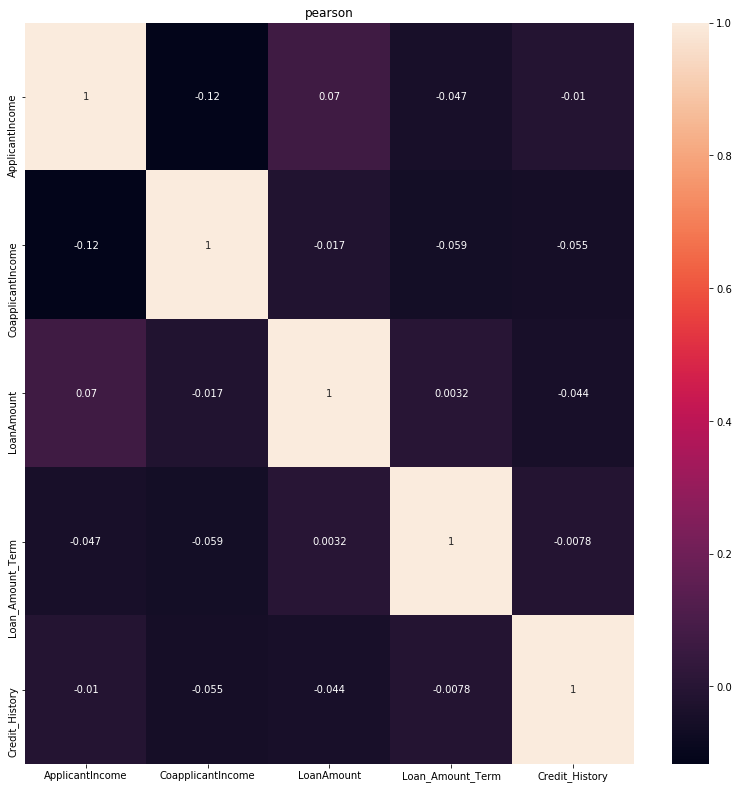

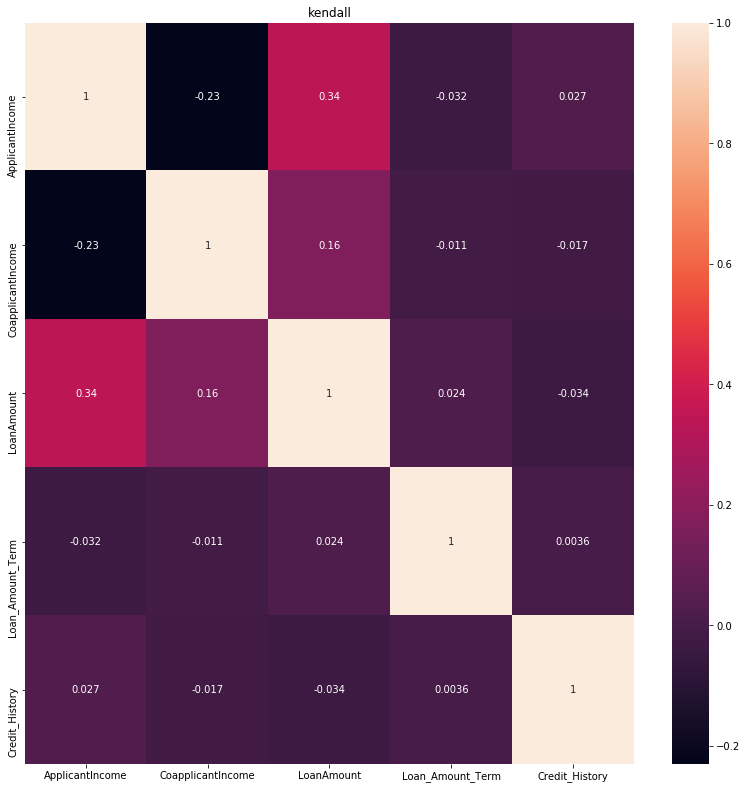

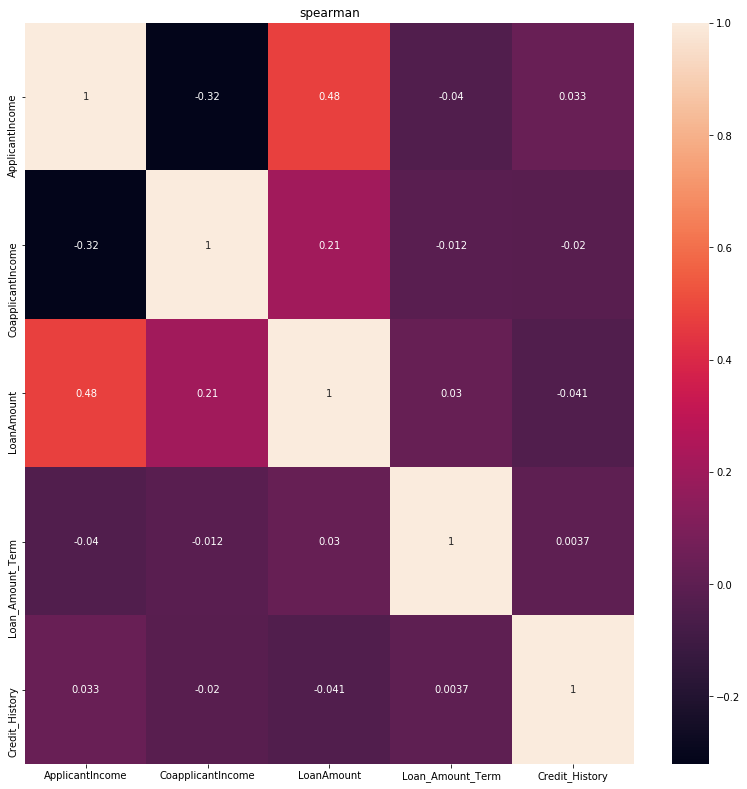

In [495]:
correlation_matrix(df_cleaned)

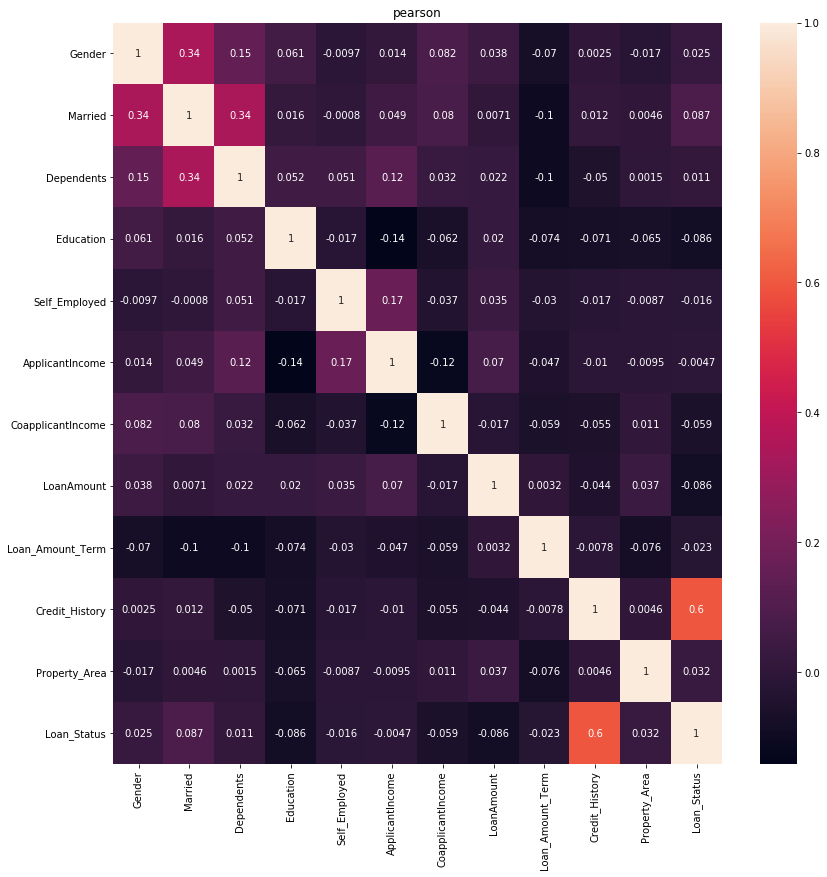

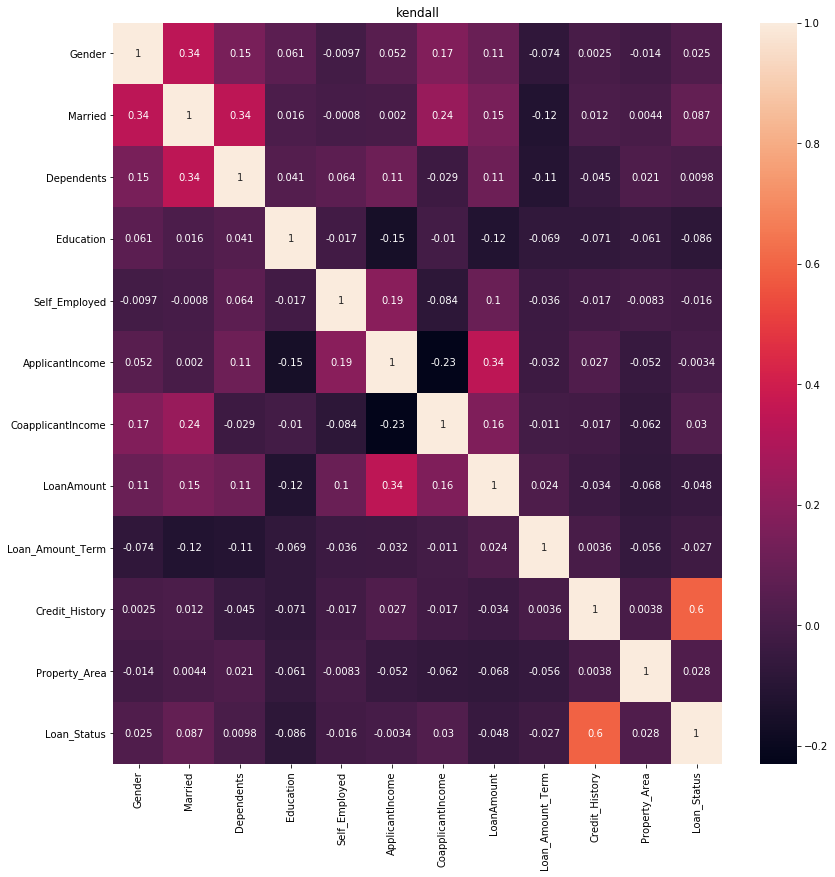

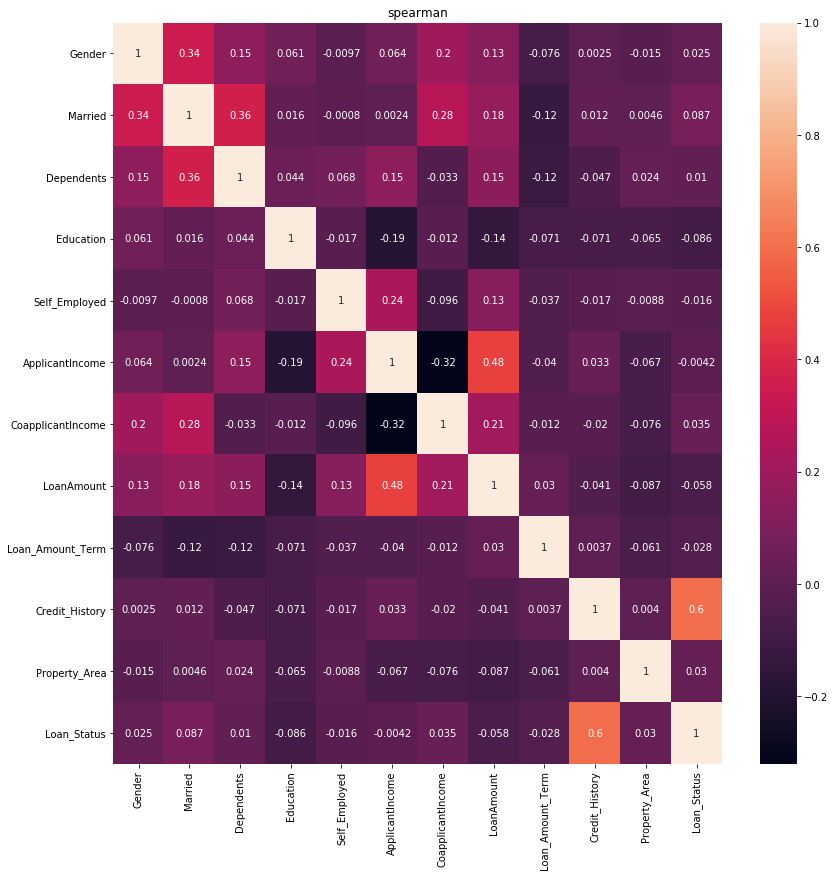

In [496]:
correlation_matrix(df_catnum)

Ces matrices de corrélation ne nous apprennent pas grand chose pour ce qui est des variables quantitatives en même temps dans un cas de classification s'était à prévoir... 

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

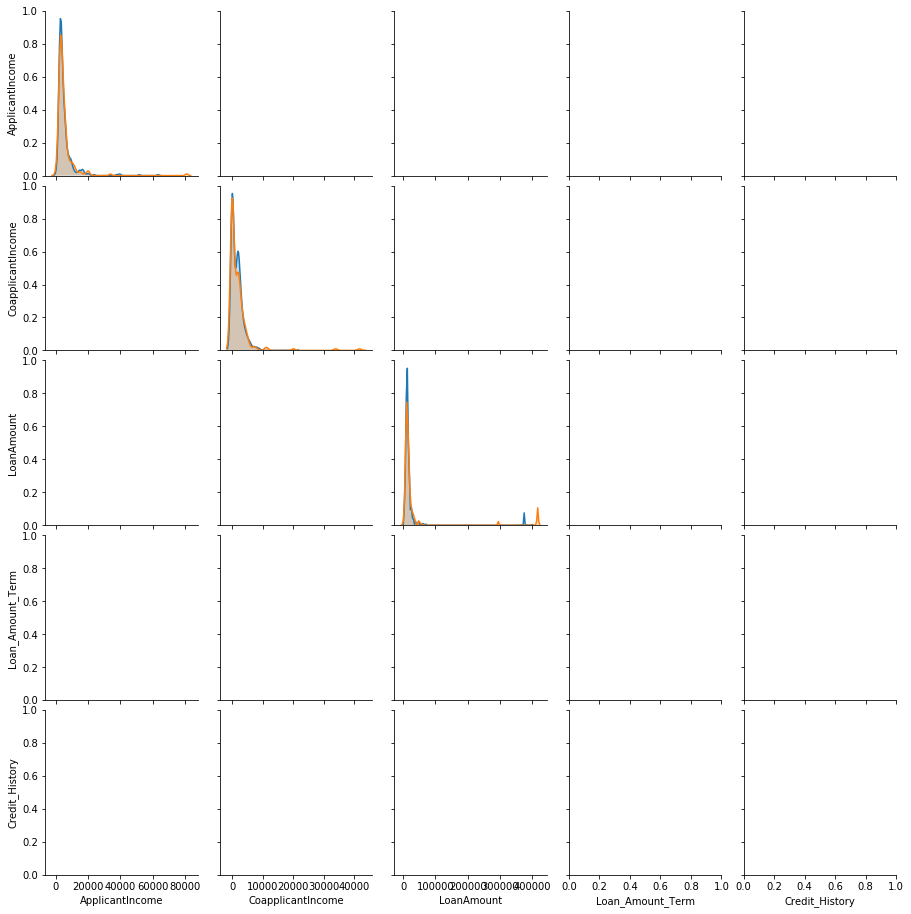

In [497]:
sns.pairplot(df_cleaned, hue="Loan_Status")

In [ ]:
sns.relplot("LoanAmount", "ApplicantIncome", hue="Loan_Status", data=df_cleaned.loc[(df_cleaned['ApplicantIncome']< 25000)&(df_cleaned['LoanAmount']<100000)])


In [ ]:
sns.relplot("LoanAmount", "CoapplicantIncome", hue="Loan_Status", data=df_cleaned.loc[(df_cleaned['CoapplicantIncome']< 15000)&(df_cleaned['LoanAmount']<100000)])

#### Conclusion

Rien ne semble très pertinent concernant les données numériques. Cependant dans ces visualisation on remarque que nos outliers nuisent aux visualisation et donc potentielement aux modèles.
On va donc : 
<ul><li>Enlever les samples qui ont un ApplicantIncome supérieur à 25k</li>
    <li>Enlever les samples qui ont un LoanAmount supérieur à 100k</li>
    <li>Enlever les samples qui ont un CoapplicantIncome supérieur à 15k</li></ul>
On va stoker celà dans 3 nouvelle variables afin de ne pas perdre nos précédents changements.

## <a id="14"> Nettoyage des Outliers</a>

In [ ]:
df_cleaned2=df_cleaned.copy()
df_catnum2=df_catnum.copy()
df_encoded2=df_encoded.copy()

In [ ]:
df_cleaned2=df_cleaned2.loc[(df_cleaned2['ApplicantIncome']< 25000)&(df_cleaned2['LoanAmount']<100000)&(df_cleaned['CoapplicantIncome']< 15000)]
df_encoded2=df_encoded.loc[(df_encoded2['ApplicantIncome']< 25000)&(df_encoded2['LoanAmount']<100000)&(df_encoded2['CoapplicantIncome']< 15000)]
df_catnum2=df_catnum2.loc[(df_catnum2['ApplicantIncome']< 25000)&(df_catnum2['LoanAmount']<100000)&(df_catnum2['CoapplicantIncome']< 15000)]

In [ ]:
df_cleaned2

In [ ]:
df_cleaned

In [ ]:
print("On a perdu :"+str(round(1-len(df_cleaned2)/len(df_cleaned),3)*100)+ " % de nos données avec la suppression de nos outliers")

### <a id="15"> Etude des variables</a>

In [ ]:
#On séparre nos variable quantitative et Qualitative ainsi que notre target. 
X_quanti=df_catnum2.iloc[:,6:10]
X_quali=df_catnum2.iloc[:,[1,2,3,4,5,10,11]]
Y=df_catnum2["Loan_Status"]

In [ ]:
X_quanti

On utilise deux methodes dans notre fonction KBest :
<ul><li>Chi2: Pour tester les valeurs qualitative</li>
    <li>f_classif(Annova): Pour tester les valeurs quantitative</li></ul>
    
Sans rentrer dans les détails : Le Khi2 va vérifié l'indépendance de la variance d'une variable qualitative par rapport à l'hypothése null.

L'anova compare la variance de la variance d'une variable quantitative par rapport à une catégorial. 

Dans notre cas on va tester l'ensemble de nos variables avec notre target pour voir si elle sont importante pour prédire notre target.

In [ ]:
Selector_Quali= SelectKBest(chi2,k=5)
Selector_Quanti= SelectKBest(f_classif,k=4)

In [ ]:
Selector_Quali.fit_transform(X_quali,Y)

In [ ]:
Selector_Quali.get_support()

In [ ]:
chi,pchi=chi2(X_quali,Y)

In [ ]:
a=pd.Series(chi, index=X_quali.columns).sort_values(ascending=False)
sns.barplot(x=a, y=a.index)

In [ ]:
X_qualiE= df_encoded2[['Female', 'Male', 'Not_Married', 'Married_',
       '0_dep', '1_dep', '2_dep', '3m_dep', 'Graduate', 'Not_Graduate',
       'Employed_', 'Self_Employed_', 'Rural', 'SemiUrban', 'Urban',
       'Never_Credit', 'Already_Credit']]
chi,pchi=chi2(X_qualiE,Y)
aE=pd.Series(chi, index=X_qualiE.columns).sort_values(ascending=False)
sns.barplot(x=aE, y=aE.index)

In [ ]:
df_encoded2.columns

In [ ]:
Selector_Quanti.fit_transform(X_quanti,Y)

In [ ]:
Selector_Quanti.get_support()

In [ ]:
F,pF=f_classif(X_quanti,Y)

In [ ]:
print(pF)
print(F)

In [ ]:
b=pd.Series(F,index=X_quanti.columns).sort_values(ascending=False)
sns.barplot(x=b, y=b.index)

#### Conclusion 

On a donc pu étudier l'importance de nos features à la fois numériques et catégorielles.
On peut isoler 2 features numérique qui se détachent des autres voir une grosse importance. 


### <a id='16'><center><font color="INDIANRED">10)Création de Features</font></center></a>

Nous allons maintenant tenté de créer un certain nombre de nouvelle Features dérivé d'autres features pré-existante:
<ul><li>Total Income = ApplicantIncome + CoaaplicantIncome</li>
    <li>Income_pondéré= Total_Income / (dependent + 1 if married)</li>
    <li>Mois_d'échéance= LoanAmount / Loan_Amount_Term</li></ul>
Nous referons ensuite des test parametrique Anova avec toutes ces features pour déterminer quels features nous garderons.

In [ ]:
df_add_F=df_catnum2.copy()

In [ ]:
#La plus simple d'abords Total Income
df_add_F['Total_Income']=df_add_F['ApplicantIncome']+df_add_F['CoapplicantIncome']

In [ ]:
df_add_F

In [ ]:
#Assez facile aussi: Le nombre de mois d'échéance arrondie. 
df_add_F['Refund_Time']= round(df_add_F["LoanAmount"]/df_add_F['Loan_Amount_Term'],0)

In [ ]:
df_add_F

In [ ]:
#Enfin plus compliqué on va calculé notre income pondéré.

#En deux étapes: 

#On créer une colonnes family qui compte le nombre de personnes dans le foyer (Applicant Compris)
df_add_F['Family']= np.where(df_add_F['Married']==0, 2+df_add_F['Dependents'],1+df_add_F['Dependents'])

#On divise l'income total dans par ce chiffre. 
df_add_F['Income_pond']=df_add_F['Total_Income']/df_add_F['Family']

In [ ]:
df_add_F.drop(["refund_time"], axis=1, inplace=True)
df_add_F

#### Conclusion
on a maintenant 4 nouvelle Features quantitative il va falloir tester si elle sont importante ou pas ! 

In [ ]:
X2_quanti= df_add_F.iloc[:,[6,7,8,9,15,16,17,18]]

In [ ]:
X2_quanti

In [ ]:
Fu,pFu=f_classif(X2_quanti,Y)

In [ ]:
c=pd.Series(Fu,index=X2_quanti.columns).sort_values(ascending=False)
sns.barplot(x=c, y=c.index)

In [ ]:
Selector_Quanti.fit_transform(X2_quanti,Y)

In [ ]:
Selector_Quanti.get_support()

In [ ]:
df_cleaned2[["Total_Income","Refund_Time","Family","Income_pond"]]=df_add_F[["Total_Income","Refund_Time","Family","Income_pond"]]
df_encoded2[["Total_Income","Refund_Time","Family","Income_pond"]]=df_add_F[["Total_Income","Refund_Time","Family","Income_pond"]]
df_catnum2[["Total_Income","Refund_Time","Family","Income_pond"]]=df_add_F[["Total_Income","Refund_Time","Family","Income_pond"]]

####  Conclusion 
Il semble que les variables Family et Refund Time apporte un léger plus à notre model.

### <a id='17'><center><font color="INDIANRED">11)Equilibrage</font></center></a>

1    0.689884
0    0.310116
Name: Loan_Status, dtype: float64


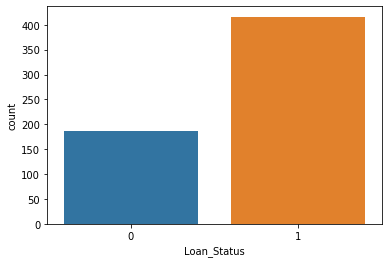

In [498]:
sns.countplot(df_add_F['Loan_Status'])
print(df_add_F['Loan_Status'].value_counts()/len(df_add_F))

Comme on l'avais déjà vu il existe un déséquilibre plutôt marqué entre nos deux target (30% pour 70%). 
Nous allons créer deux nouveau set de donnée pour chacune de nos df préexistante une avec smote et une avec oversampling.

(ça va commencer à faire beaucoup de df, je vais donc créer une fonction qui récap les df.

In [499]:
df_list=["df_cleaned","df_cleaned2","df_encoded","df_encoded2","df_catnum","df_catnum2"]
df_description=["DF nettoyer aucun changement de variable",
               "V2 : Outlier enlevé et variable ajouté",
              "DF nettoyer et One hot Encoder",
              "V2 : Outlier enlevé et variable ajouté",
              "DF nettoyer Variable Catégorielle passé en numérique",
              "V2 : Outlier enlevé et variable ajouté"]
def list_DF (inti, desc):         
    df_list.append(inti)
    df_description.append(desc)
    d = {'Df_Name': df_list, 'Df_Description': df_description}
    return pd.DataFrame(data=d)

In [500]:
D=list_DF("df_cleaned_smote","V3 smoted")
D=list_DF("df_encoded_smote","V3 smoted")
D=list_DF("df_catnum_smote","V3 smoted")
D=list_DF("df_cleaned_over","V4 oversampled")
D=list_DF("df_encoded_over","V4 oversampled")
D=list_DF("df_catnum_over","V4 oversampled")

A partir de là a chaque fois que je créer un nouveau DF je le rentre dans cette fonction je n'aurais plus qu'à appeller mon DF D pour avoir la liste de mes dataframe et une courte description. 

In [501]:
D

,Df_Name,Df_Description
0,df_cleaned,DF nettoyer aucun changement de variable
1,df_cleaned2,V2 : Outlier enlevé et variable ajouté
2,df_encoded,DF nettoyer et One hot Encoder
3,df_encoded2,V2 : Outlier enlevé et variable ajouté
4,df_catnum,DF nettoyer Variable Catégorielle passé en num...
5,df_catnum2,V2 : Outlier enlevé et variable ajouté
6,df_cleaned_smote,V3 smoted
7,df_encoded_smote,V3 smoted
8,df_catnum_smote,V3 smoted
9,df_cleaned_over,V4 oversampled


In [502]:
#Je vais reorder mes colonnes afin de gagner en facilité d'écriture pour la suite en ayant ma target en dernière position
#J'en profite aussi pour drop le Loan_ID


df_encoded2=df_encoded2[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Female', 'Male', 'Not_Married',
       'Married_', '0_dep', '1_dep', '2_dep', '3m_dep', 'Graduate',
       'Not_Graduate', 'Employed_', 'Self_Employed_', 'Rural', 'SemiUrban',
       'Urban', 'Never_Credit', 'Already_Credit', 'Total_Income',
       'Refund_Time', 'Family', 'Income_pond','Loan_Status']]
df_encoded2

KeyError: "['2_dep', 'Rural', '0_dep', 'Not_Graduate', 'Not_Married', 'Already_Credit', 'Graduate', 'Female', '1_dep', 'Never_Credit', 'SemiUrban', 'Urban', 'Employed_', 'Married_', '3m_dep', 'Self_Employed_', 'Male'] not in index"

In [503]:
df_cleaned2.columns
df_cleaned2=df_cleaned2[['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 
       'Total_Income', 'Refund_Time', 'Family', 'Income_pond','Loan_Status']]
df_cleaned2

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income,Refund_Time,Family,Income_pond,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,3750.0,360.0,1.0,Urban,5849.0,10.0,2,2924.500000,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,6091.0,0.0,2,3045.500000,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,3000.0,0.0,1,3000.000000,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,4941.0,0.0,1,4941.000000,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,6000.0,0.0,2,3000.000000,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,2900.0,0.0,2,1450.000000,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,4106.0,0.0,4,1026.500000,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,8312.0,1.0,2,4156.000000,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,7583.0,1.0,3,2527.666667,Y


In [504]:
#J'en profite pour virer un doublon male et female. 
df_catnum2.columns
df_catnum2=df_catnum2[['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area',
       'Total_Income', 'Refund_Time', 'Family',
       'Income_pond', 'Loan_Status']]
df_catnum2

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income,Refund_Time,Family,Income_pond,Loan_Status
0,1,0,0,0,0,5849,0.0,3750.0,360.0,1.0,2,5849.0,10.0,2,2924.500000,1
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,6091.0,0.0,2,3045.500000,0
2,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,3000.0,0.0,1,3000.000000,1
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,4941.0,0.0,1,4941.000000,1
4,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,6000.0,0.0,2,3000.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,0,0,2900,0.0,71.0,360.0,1.0,0,2900.0,0.0,2,1450.000000,1
610,1,1,3,0,0,4106,0.0,40.0,180.0,1.0,0,4106.0,0.0,4,1026.500000,1
611,1,1,1,0,0,8072,240.0,253.0,360.0,1.0,2,8312.0,1.0,2,4156.000000,1
612,1,1,2,0,0,7583,0.0,187.0,360.0,1.0,2,7583.0,1.0,3,2527.666667,1


In [505]:
#Notre loan_status est maintenant en dernière position poursuivons
df_encoded_smote=df_encoded2.copy()
df_cleaned_smote=df_cleaned2.copy()
df_catnum_smote=df_catnum2.copy()

In [506]:
smote = SMOTE()
df_encoded_smote, y= smote.fit_sample(df_encoded_smote.iloc[:, 0:-1], df_encoded_smote['Loan_Status'])

ValueError: could not convert string to float: 'LP001002'

In [507]:
df_encoded_smote["Loan_Status"]=y

In [508]:
df_encoded_smote

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Total_Income,Refund_Time,Family,Income_pond
0,LP001002,5849,0.0,3750.0,360.0,1,5849.0,10.0,2,2924.500000
1,LP001003,4583,1508.0,128.0,360.0,0,6091.0,0.0,2,3045.500000
2,LP001005,3000,0.0,66.0,360.0,1,3000.0,0.0,1,3000.000000
3,LP001006,2583,2358.0,120.0,360.0,1,4941.0,0.0,1,4941.000000
4,LP001008,6000,0.0,141.0,360.0,1,6000.0,0.0,2,3000.000000
...,...,...,...,...,...,...,...,...,...,...
609,LP002978,2900,0.0,71.0,360.0,0,2900.0,0.0,2,1450.000000
610,LP002979,4106,0.0,40.0,180.0,0,4106.0,0.0,4,1026.500000
611,LP002983,8072,240.0,253.0,360.0,0,8312.0,1.0,2,4156.000000
612,LP002984,7583,0.0,187.0,360.0,0,7583.0,1.0,3,2527.666667


In [509]:
sns.countplot(df_encoded_smote['Loan_Status']

SyntaxError: unexpected EOF while parsing (<ipython-input-509-8da9d4b0445c>, line 1)

In [510]:
df_catnum_smote, y= smote.fit_sample(df_catnum_smote.iloc[:, 0:-1], df_catnum_smote['Loan_Status'])
df_catnum_smote["Loan_Status"]=y

In [511]:
df_catnum_smote

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income,Refund_Time,Family,Income_pond,Loan_Status
0,1,0,0,0,0,5849,0.000000,3750.000000,360.000000,1.000000,2,5849.000000,10.000000,2,2924.500000,1
1,1,1,1,0,0,4583,1508.000000,128.000000,360.000000,1.000000,0,6091.000000,0.000000,2,3045.500000,0
2,1,1,0,0,1,3000,0.000000,66.000000,360.000000,1.000000,2,3000.000000,0.000000,1,3000.000000,1
3,1,1,0,1,0,2583,2358.000000,120.000000,360.000000,1.000000,2,4941.000000,0.000000,1,4941.000000,1
4,1,0,0,0,0,6000,0.000000,141.000000,360.000000,1.000000,2,6000.000000,0.000000,2,3000.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,1,1,2,0,0,6423,0.000000,464.046127,360.000000,0.921801,0,6423.751113,0.938385,3,1649.162130,0
828,1,0,0,0,0,3787,0.000000,99.284831,444.221297,1.000000,2,3787.269482,0.000000,2,1893.634741,0
829,1,1,0,0,0,3755,5511.246641,127.568349,332.386807,0.153407,0,9266.705915,0.000000,1,5308.035309,0
830,1,1,0,0,0,3436,1949.345118,119.587522,360.000000,0.000000,1,5386.221607,0.000000,1,5386.221607,0


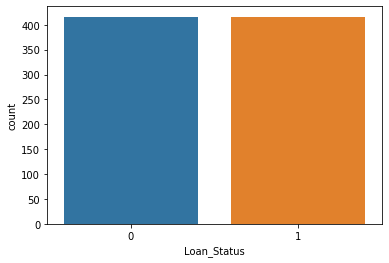

In [512]:
sns.countplot(df_catnum_smote['Loan_Status'])

In [513]:
#Evidement on ne peut pas appliquer cette algo sur notre df cleaned car il a encore des variables non numérique. 

In [514]:
df_catnum_over=df_catnum2.copy()
df_encoded_over=df_encoded2.copy()
df_cleaned_over=df_cleaned2.copy()
ovr = RandomOverSampler()

In [519]:
df_encoded_over.to_csv("df_guillaume.csv", index = False)

In [520]:

df_catnum_over, y_cat = ovr.fit_sample(df_catnum_over.iloc[:, 0:-1], df_catnum_over['Loan_Status'])
df_encoded_over, y_en = ovr.fit_sample(df_encoded_over.iloc[:, 0:-1], df_encoded_over['Loan_Status'])
df_cleaned_over, y_cl = ovr.fit_sample(df_cleaned_over.iloc[:, 0:-1], df_cleaned_over['Loan_Status'])
df_cleaned_over['Loan_Status']=y_cl
df_encoded_over['Loan_Status']=y_en
df_catnum_over['Loan_Status']=y_cat

In [521]:
df_catnum_over

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income,Refund_Time,Family,Income_pond,Loan_Status
0,1,0,0,0,0,5849,0.0,3750.0,360.0,1.0,2,5849.0,10.0,2,2924.500000,1
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,6091.0,0.0,2,3045.500000,0
2,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,3000.0,0.0,1,3000.000000,1
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,4941.0,0.0,1,4941.000000,1
4,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,6000.0,0.0,2,3000.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,1,0,0,0,0,14999,0.0,242.0,360.0,0.0,1,14999.0,1.0,2,7499.500000,0
828,1,1,1,0,0,2787,1917.0,146.0,360.0,0.0,0,4704.0,0.0,2,2352.000000,0
829,1,1,0,1,0,3523,3230.0,152.0,360.0,0.0,0,6753.0,0.0,1,6753.000000,0
830,0,1,2,0,0,2873,1872.0,132.0,360.0,0.0,1,4745.0,0.0,3,1581.666667,0


In [522]:
df_cleaned_over

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income,Refund_Time,Family,Income_pond,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,3750.0,360.0,1.0,Urban,5849.0,10.0,2,2924.500000,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,6091.0,0.0,2,3045.500000,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,3000.0,0.0,1,3000.000000,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,4941.0,0.0,1,4941.000000,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,6000.0,0.0,2,3000.000000,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,Male,No,0,Graduate,Yes,16250,0.0,192.0,360.0,0.0,Urban,16250.0,1.0,2,8125.000000,N
828,Male,Yes,0,Not Graduate,Yes,4344,736.0,87.0,360.0,1.0,Semiurban,5080.0,0.0,1,5080.000000,N
829,Male,Yes,3+,Graduate,No,6406,0.0,150.0,360.0,1.0,Semiurban,6406.0,0.0,4,1601.500000,N
830,Male,Yes,0,Graduate,No,2221,0.0,60.0,360.0,0.0,Urban,2221.0,0.0,1,2221.000000,N


In [523]:
df_encoded_over

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Total_Income,Refund_Time
0,LP001002,5849,0.0,3750.0,360.0,1,5849.0,10.0
1,LP001003,4583,1508.0,128.0,360.0,0,6091.0,0.0
2,LP001005,3000,0.0,66.0,360.0,1,3000.0,0.0
3,LP001006,2583,2358.0,120.0,360.0,1,4941.0,0.0
4,LP001008,6000,0.0,141.0,360.0,1,6000.0,0.0
...,...,...,...,...,...,...,...,...
827,LP001036,3510,0.0,76.0,360.0,0,3510.0,0.0
828,LP001020,12841,10968.0,349.0,360.0,0,23809.0,1.0
829,LP001097,4692,0.0,106.0,360.0,0,4692.0,0.0
830,LP002729,11250,0.0,196.0,360.0,0,11250.0,1.0


#### conclusion on a donc 5 jeux de données équilibré.

### <a id='18'><center><font color="INDIANRED">12) PCA</font></center></a>

La PCA permet de réduire les dimensions de nos variables il ne prend en compte que des variables numérique. Ici nous n'avons que peu de variable numérique qui plus est peu importante pour le modèle un PCA ne semble pas cohérent. 

Essayons quand même en faisant une PCA sur notre tableau avec le plus de variable df_encoded.

Nous le feront pour les deux versions équilibré et la version déséquilibré de ce DF.

In [524]:
# définition de la commande
pca = PCA()
# Sélection des variables quantitatives
dat_smote=df_encoded_smote.iloc[:,:-1]
dat_over=df_encoded_over.iloc[:,:-1]
dat_dez=df_encoded2.iloc[:,:-1]

# réduction
data_smote = pd.DataFrame(scale(dat_smote),columns=dat_smote.columns)
data_over= pd.DataFrame(scale(dat_over),columns=dat_over.columns)
data_dez=pd.DataFrame(scale(dat_dez),columns=dat_dez.columns)
# composantes principales
C_smote = pca.fit(data_smote).transform(data_smote)

print("Pourcentage de variance expliquée cumulatif: ")
print(np.cumsum(pca.explained_variance_ratio_))


ValueError: could not convert string to float: 'LP001002'

In [525]:
C_over = pca.fit(data_over).transform(data_over)


NameError: name 'data_over' is not defined

In [526]:
C_dez= pca.fit(data_dez).transform(data_dez)
print("Pourcentage de variance expliquée cumulatif: ")
print(np.cumsum(pca.explained_variance_ratio_))

NameError: name 'data_dez' is not defined

Comme on pouvait s'en douter les résultat ne sont très intéressant il faut monté 8 Composante pour n'avoir que 73% de variance expliquée. Celà est probablement du au fait que nombre de mes variables sont qualitative.
Je vais garder la version oversampled avec 9 composante pour faire la comparaison.

In [527]:
len(C_over)

NameError: name 'C_over' is not defined

In [528]:
df_PCA=pd.DataFrame(C_over)

NameError: name 'C_over' is not defined

In [529]:
df_PCA=df_PCA.iloc[:,:8]

NameError: name 'df_PCA' is not defined

In [530]:
df_PCA['Loan_Status']=df_encoded_over['Loan_Status']


NameError: name 'df_PCA' is not defined

In [ ]:
df_PCA

In [ ]:
D= list_DF("df_PCA","Donnée du PCA sur la df_encoded_oversampled")

In [ ]:
D

### <a id='19'><center><font color="INDIANRED">13) Normalisation</font></center></a>

In [539]:
df_encoded_over

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Total_Income,Refund_Time
0,LP001002,5849,0.0,3750.0,360.0,1,5849.0,10.0
1,LP001003,4583,1508.0,128.0,360.0,0,6091.0,0.0
2,LP001005,3000,0.0,66.0,360.0,1,3000.0,0.0
3,LP001006,2583,2358.0,120.0,360.0,1,4941.0,0.0
4,LP001008,6000,0.0,141.0,360.0,1,6000.0,0.0
...,...,...,...,...,...,...,...,...
827,LP001036,3510,0.0,76.0,360.0,0,3510.0,0.0
828,LP001020,12841,10968.0,349.0,360.0,0,23809.0,1.0
829,LP001097,4692,0.0,106.0,360.0,0,4692.0,0.0
830,LP002729,11250,0.0,196.0,360.0,0,11250.0,1.0


Dernière étape de notre pre-processing nous allons créer des version normaliser de nos df grâce à la fonction scale de sklearn.

In [531]:
norm_encoded_over=df_encoded_over.copy()
norm_encoded_over[['ApplicantIncome', 'CoapplicantIncome','LoanAmount','Total_Income', 'Refund_Time',
       'Family', 'Income_pond','Loan_Amount_Term']]= scale(norm_encoded_over[['ApplicantIncome', 'CoapplicantIncome','LoanAmount','Total_Income', 'Refund_Time',
       'Family', 'Income_pond','Loan_Amount_Term']])
#D=list_DF("norm_encoded_over","Normalize version")

KeyError: "['Family', 'Income_pond'] not in index"

In [533]:
df_encoded2

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Total_Income,Refund_Time,Family,Income_pond
0,LP001002,5849,0.0,3750.0,360.0,1,5849.0,10.0,2,2924.500000
1,LP001003,4583,1508.0,128.0,360.0,0,6091.0,0.0,2,3045.500000
2,LP001005,3000,0.0,66.0,360.0,1,3000.0,0.0,1,3000.000000
3,LP001006,2583,2358.0,120.0,360.0,1,4941.0,0.0,1,4941.000000
4,LP001008,6000,0.0,141.0,360.0,1,6000.0,0.0,2,3000.000000
...,...,...,...,...,...,...,...,...,...,...
609,LP002978,2900,0.0,71.0,360.0,1,2900.0,0.0,2,1450.000000
610,LP002979,4106,0.0,40.0,180.0,1,4106.0,0.0,4,1026.500000
611,LP002983,8072,240.0,253.0,360.0,1,8312.0,1.0,2,4156.000000
612,LP002984,7583,0.0,187.0,360.0,1,7583.0,1.0,3,2527.666667


In [534]:
norm_encoded=df_encoded2.copy()
norm_encoded[['ApplicantIncome', 'CoapplicantIncome','LoanAmount','Total_Income', 'Refund_Time',
       'Family', 'Income_pond','Loan_Amount_Term']]= scale(norm_encoded[['ApplicantIncome', 'CoapplicantIncome','LoanAmount','Total_Income', 'Refund_Time',
       'Family', 'Income_pond','Loan_Amount_Term']])
D=list_DF("norm_encoded","Normalize version")

In [535]:
norm_encoded_smote=df_encoded_smote.copy()
norm_encoded_smote[['ApplicantIncome', 'CoapplicantIncome','LoanAmount','Total_Income', 'Refund_Time',
       'Family', 'Income_pond','Loan_Amount_Term']]= scale(norm_encoded_smote[['ApplicantIncome', 'CoapplicantIncome','LoanAmount','Total_Income', 'Refund_Time',
       'Family', 'Income_pond','Loan_Amount_Term']])
D=list_DF("norm_encoded_smote","Normalize version")

In [536]:
norm_catnum_smote=df_catnum_smote.copy()
norm_catnum_smote[['ApplicantIncome', 'CoapplicantIncome','LoanAmount','Total_Income', 'Refund_Time',
       'Family', 'Income_pond','Loan_Amount_Term']]= scale(norm_catnum_smote[['ApplicantIncome', 'CoapplicantIncome','LoanAmount','Total_Income', 'Refund_Time',
       'Family', 'Income_pond','Loan_Amount_Term']])
D=list_DF("norm_catnum_smote","Normalize version")

In [537]:
norm_catnum_over=df_catnum_over.copy()
norm_catnum_over[['ApplicantIncome', 'CoapplicantIncome','LoanAmount','Total_Income', 'Refund_Time',
       'Family', 'Income_pond','Loan_Amount_Term']]= scale(norm_catnum_over[['ApplicantIncome', 'CoapplicantIncome','LoanAmount','Total_Income', 'Refund_Time',
       'Family', 'Income_pond','Loan_Amount_Term']])
D=list_DF("norm_catnum_over","Normalize version")

In [538]:
norm_catnum=df_catnum2.copy()
norm_catnum[['ApplicantIncome', 'CoapplicantIncome','LoanAmount','Total_Income', 'Refund_Time',
       'Family', 'Income_pond','Loan_Amount_Term']]= scale(norm_catnum[['ApplicantIncome', 'CoapplicantIncome','LoanAmount','Total_Income', 'Refund_Time',
       'Family', 'Income_pond','Loan_Amount_Term']])
D=list_DF("norm_catnum","Normalize version")

In [ ]:
D

#### Conclusion 

Nous avons maintenant 18 DF. Nous ne les utiliserons probablement pas tous car certain vont être redondant. 
Les DF cleaned n'ont pas beaucoup d'intérêt par rapport au DF catnum nous les ignorerons donc. Les V1 des DF ne vont pas non plus apporter grand chose du coup nous avons déjà éliminé 6 DF. Ils nous restent donc 12 Dataframe "différents".

Ajoutons à celà que nous allons d'abords nourrir les modèles de nos DF entier et que par la suite nous nous focaliseront sur les Features les plus importantes.

Il est temps de réfléchir à notre modélisation.

## Modélisation

### <a id='20'><center><font color="INDIANRED">14) Modélisation</font></center></a>

### <a id="21">Choix des modèles</a>

Nous sommes dans un cas de classification avec beaucoup de variable catégorique. Celà nous donne déjà une piste sur les modèles a implémenter. Nous pouvons donc partir sur:
<ul><li>Logistic Regression</li>
    <li>Decision Tree Classifier</li>
    <li>Random Forest Classifier</li>
    <li>XGboost Classifier</li>
    <li>SVM classifier</li></ul>

Tout d'abords commençons par créer une fonction qui va executer nos différents modèles pour chacun de nos jeux de données (Je rappelle que nous en avons potentielement 36 à tester sur donc 5 modèles soit 180 résultats) il va donc falloir essayer d'être efficace.

In [ ]:
#Fonction qui execute nos différents modèles pour un jeu de donnée fixé (Merci Ambre, Nico, Hana et Orkun) et les stock
#Dans un dataframe propre.

models = []
sampling = []
w_pca = []
encoded=[]
normalize =[]
feature=[]
accuracy = []
precision = []
recall = []


#Pour l'instant étant donné les restrictions de planning je vais me contenter des parametre de base je modifierais
#Par la suite.

def add_models (X_train, y_train, X_test, y_test, sampling_name, pca_presence, norma,feat, onehot):
    
    for x in range(1):
        lr = LogisticRegression(max_iter = 1000).fit(X_train,y_train)
        result_lr = lr.predict(X_test)
        models.append("LogisticRegression")
        sampling.append(sampling_name)
        w_pca.append(pca_presence)
        normalize.append(norma)
        feature.append(feat)
        encoded.append(onehot)
        accuracy.append(accuracy_score(y_test, result_lr))
        precision.append(precision_score(y_test, result_lr))
        recall.append(recall_score(y_test, result_lr))
        
        clf = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
        result_clf = clf.predict(X_test)
        models.append("DecisionTree")
        sampling.append(sampling_name)
        w_pca.append(pca_presence)
        normalize.append(norma)
        feature.append(feat)
        encoded.append(onehot)
        accuracy.append(accuracy_score(y_test, result_clf))
        precision.append(precision_score(y_test, result_clf))
        recall.append(recall_score(y_test, result_clf))
        
        rfc = RandomForestClassifier().fit(X_train, y_train)
        result_rfc = rfc.predict(X_test)
        models.append("RandomForest")
        sampling.append(sampling_name)
        w_pca.append(pca_presence)
        normalize.append(norma)
        feature.append(feat)
        encoded.append(onehot)
        accuracy.append(accuracy_score(y_test, result_rfc))
        precision.append(precision_score(y_test, result_rfc))
        recall.append(recall_score(y_test, result_rfc))
        
        xgb = XGBClassifier().fit(X_train, y_train)
        result_xgb = xgb.predict(X_test)
        models.append("XGBClassifier")
        sampling.append(sampling_name)
        w_pca.append(pca_presence)
        normalize.append(norma)
        feature.append(feat)
        encoded.append(onehot)
        accuracy.append(accuracy_score(y_test, result_xgb))
        precision.append(precision_score(y_test, result_xgb))
        recall.append(recall_score(y_test, result_xgb))
            
        svm = svml.SVC().fit(X_train, y_train)
        result_svm = svm.predict(X_test)
        models.append("Support Vector Machine")
        sampling.append(sampling_name)
        w_pca.append(pca_presence)
        normalize.append(norma)
        feature.append(feat)
        encoded.append(onehot)
        accuracy.append(accuracy_score(y_test, result_svm))
        precision.append(precision_score(y_test, result_svm))
        recall.append(recall_score(y_test, result_svm))

### <a id="22">Full Data modeling</a>

#### df_encoded

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_encoded2.iloc[:,:-1],df_encoded2[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "No", "No","No","Full","Yes")

#### df_catnum

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_catnum2.iloc[:,:-1],df_catnum2[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "No", "No","No","Full","No")

#### df_encoded_smote

In [ ]:
X_train, X_test, y_train, y_test =(
    train_test_split(df_encoded_smote.iloc[:,:-1],df_encoded_smote[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Smote", "No","No","Full","Yes")

#### df_encoded_over

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_encoded_over.iloc[:,:-1],df_encoded_over[["Loan_Status"]], train_size=0.8))


In [ ]:
add_models(X_train, y_train, X_test, y_test, "Oversampling", "No","No","Full","Yes")

#### df_catnum_smote

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_catnum_smote.iloc[:,:-1],df_catnum_smote[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Smote", "No","No","Full","No")

#### df_catnum_over

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_catnum_over.iloc[:,:-1],df_catnum_over[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Oversampling", "No","No","Full","No")

#### norm_encoded

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_encoded.iloc[:,:-1],norm_encoded[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "No", "No","Yes","Full","Yes")

#### norm_encoded_smote

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_encoded_smote.iloc[:,:-1],norm_encoded_smote[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Smote", "No","Yes","Full","Yes")

#### norm_encoded_over

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_encoded_over.iloc[:,:-1],norm_encoded_over[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Oversampling", "No","Yes","Full","Yes")

#### norm_catnum

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_catnum.iloc[:,:-1],norm_catnum[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "No", "No","Yes","Full","No")

#### norm_catnum_smote

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_catnum_smote.iloc[:,:-1],norm_catnum_smote[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Smote", "No","Yes","Full","No")

#### norm_catnum_over

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_catnum_over.iloc[:,:-1],norm_catnum_over[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Oversampling", "No","Yes","Full","No")

#### df_PCA

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_PCA.iloc[:,:-1],df_PCA[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Oversampling", "Yes","Yes","8 componant","Yes")

### <a id="23"> Only Best Features </a>

Prenons deux de nos dataframe les plus complet et non modifié(Df_encoded_over et df_catnum_over)et utilisons notre modèle Random Forest qui va nous permettre de visualiser l'importance de nos features.   

#### Encoded_Over

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_encoded_over.iloc[:,:-1],df_encoded_over[["Loan_Status"]], train_size=0.8))

In [ ]:
rfc = RandomForestClassifier().fit(X_train, y_train)
result_rfc = rfc.predict(X_test)

In [ ]:
rfc.feature_importances_

In [ ]:
feature_imp = pd.Series(rfc.feature_importances_, index=df_encoded_over.iloc[:,:-1].columns).sort_values(ascending=False)
plt.figure(figsize=(15,20))
sns.barplot(x=feature_imp, y=feature_imp.index)

#### Catnum_Over

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_catnum_over.iloc[:,:-1],df_catnum_over[["Loan_Status"]], train_size=0.8))

In [ ]:
rfc = RandomForestClassifier().fit(X_train, y_train)
result_rfc = rfc.predict(X_test)

In [ ]:
feature_imp = pd.Series(rfc.feature_importances_, index=df_catnum_over.iloc[:,:-1].columns).sort_values(ascending=False)
plt.figure(figsize=(15,20))
sns.barplot(x=feature_imp, y=feature_imp.index)

#### Note c'est très intéressant de voir que les features applicantincome / Total Income / pondincome soient beaucoup remonté par rapport aux résultat de notre K-Best.

#### Cependant je m'intéroge sur la possibilité que ces trois features soient finalement redondante.

In [ ]:
correlation_matrix(df_catnum_smote)

Finalement on ne dépasse pas vraiment les 0.9 de corrélation je pense que je peux garder les 3. 
Je suis maintenant curieux d'appliquer la feature importance sur mes données normalisé.

In [ ]:
correlation_matrix(df_encoded_smote)

Ici par contre on voient bien que les one hot binaire ont une corélation inverse peut-être devrais-je envisager d'amputer mon jeu de données de ces doublons. 

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_catnum_over.iloc[:,:-1],norm_catnum_over[["Loan_Status"]], train_size=0.8))

In [ ]:
rfc = RandomForestClassifier().fit(X_train, y_train)
result_rfc = rfc.predict(X_test)

feature_imp = pd.Series(rfc.feature_importances_, index=df_catnum_over.iloc[:,:-1].columns).sort_values(ascending=False)
plt.figure(figsize=(15,20))
sns.barplot(x=feature_imp, y=feature_imp.index)

#### note : On retrouve les mêmes résultat !

#### On va donc partir sur deux protocoles : 
<b><ul><li>Utiliser les 8 meilleurs features choisi par notre random forest </li>
    <li>Utiliser les 6 meilleurs features choisi par nos K-best</li>
    <li>Enfin tenter une version sans doublon pour les version one hot encoder</ul></b>

In [ ]:
#Random Forest Best Features
feature_rf_encoded_doble=['Never_Credit', 'Already_Credit','Total_Income', 'Refund_Time','Income_pond','ApplicantIncome','CoapplicantIncome', 'LoanAmount']
feature_rf_encoded_no_doble=['Never_Credit','Total_Income', 'Refund_Time','Income_pond','ApplicantIncome','CoapplicantIncome', 'LoanAmount',"Loan_Amount_Term"]
feature_rf_catnum=['Credit_History', 'Property_Area', 'Total_Income','Refund_Time','Income_pond','ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

#Kbest best Features
feature_kb_catnum=['LoanAmount','Loan_Amount_Term','Refund_Time','Family','Education','Credit_History']
feature_kb_encoded_doble=['LoanAmount','Loan_Amount_Term','Refund_Time','Never_Credit','Rural', 'SemiUrban','Already_Credit']
feature_kb_encoded_no_doble=['LoanAmount','Loan_Amount_Term','Refund_Time','Never_Credit','Rural', 'SemiUrban']

### <a id="24">Partial Data Modeling</a>

#### Encoded

#### K best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_encoded2[feature_kb_encoded_doble],df_encoded2[["Loan_Status"]], train_size=0.8))

In [454]:
add_models(X_train, y_train, X_test, y_test, "No", "No","No","7 from Kbest","Yes")

NameError: name 'add_models' is not defined

#### Random Forest best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_encoded2[feature_rf_encoded_doble],df_encoded2[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "No", "No","No","8 from RandomForest","Yes")

#### Without Doublon RF

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_encoded2[feature_rf_encoded_no_doble],df_encoded2[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "No", "No","No","8 without duplicate","Yes")

#### Catnum

#### K best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_catnum2[feature_kb_catnum],df_catnum2[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "No", "No","No","6 from Kbest","No")

#### Random Forest best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_catnum2[feature_rf_catnum],df_catnum2[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "No", "No","No","8 from RandomForest","No")

#### Encoded Smote

#### K best Features

In [ ]:
X_train, X_test, y_train, y_test =(
    train_test_split(df_encoded_smote[feature_kb_encoded_doble],df_encoded_smote[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Smote", "No","No","7 from Kbest","Yes")

#### Random Forest best Features

In [ ]:
X_train, X_test, y_train, y_test =(
    train_test_split(df_encoded_smote[feature_rf_encoded_doble],df_encoded_smote[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Smote", "No","No","8 from RandomForest","Yes")

#### Without Doublon RF

In [ ]:
X_train, X_test, y_train, y_test =(
    train_test_split(df_encoded_smote[feature_rf_encoded_no_doble],df_encoded_smote[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Smote", "No","No","8 without duplicate","Yes")

#### Encoded Over

#### K best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_encoded_over[feature_kb_encoded_doble],df_encoded_over[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Oversampling", "No","No","7 from Kbest","Yes")

#### Random Forest best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_encoded_over[feature_rf_encoded_doble],df_encoded_over[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Oversampling", "No","No","8 from RandomForest","Yes")

#### Without Doublon RF

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_encoded_over[feature_rf_encoded_no_doble],df_encoded_over[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Oversampling", "No","No","8 without duplicate","Yes")

#### Catnum Smote

#### K best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_catnum_smote[feature_kb_catnum],df_catnum_smote[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Smote", "No","No","6 from Kbest","No")

#### Random Forest best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_catnum_smote[feature_rf_catnum],df_catnum_smote[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Smote", "No","No","8 from RandomForest","No")

#### Catnum Over

#### K best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_catnum_over[feature_kb_catnum],df_catnum_over[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Oversampling", "No","No","6 from Kbest","No")

#### Random Forest best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(df_catnum_over[feature_rf_catnum],df_catnum_over[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Oversampling", "No","No","8 from RandomForest","No")

#### Normalise Encoded

#### K best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_encoded[feature_kb_encoded_doble],norm_encoded[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "No", "No","Yes","7 from Kbest","Yes")

#### Random Forest best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_encoded[feature_rf_encoded_doble],norm_encoded[["Loan_Status"]], train_size=0.8))

In [455]:
add_models(X_train, y_train, X_test, y_test, "No", "No","Yes","8 from RandomForest","Yes")

NameError: name 'add_models' is not defined

#### Without Doublon RF

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_encoded[feature_rf_encoded_no_doble],norm_encoded[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "No", "No","Yes","8 without duplicate","Yes")

#### Normalise Encoded Smote

#### K best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_encoded_smote[feature_kb_encoded_doble],norm_encoded_smote[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Smote", "No","Yes","7 from Kbest","Yes")

#### Random Forest best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_encoded_smote[feature_rf_encoded_doble],norm_encoded_smote[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Smote", "No","Yes","8 from RandomForest","Yes")

#### Without Doublon RF

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_encoded_smote[feature_rf_encoded_no_doble],norm_encoded_smote[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Smote", "No","Yes","8 without duplicate","Yes")

#### Normalise Encode Over

#### K best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_encoded_over[feature_kb_encoded_doble],norm_encoded_over[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Oversampling", "No","Yes","7 from Kbest","Yes")

#### Random Forest best Features

In [456]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_encoded_over[feature_rf_encoded_doble],norm_encoded_over[["Loan_Status"]], train_size=0.8))

NameError: name 'norm_encoded_over' is not defined

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Oversampling", "No","Yes","8 from RandomForest","Yes")

#### Without doublon RF

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_encoded_over[feature_rf_encoded_no_doble],norm_encoded_over[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Oversampling", "No","Yes","8 without duplicate","Yes")

#### Normalise Catnum

#### K best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_catnum[feature_kb_catnum],norm_catnum[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "No", "No","Yes","6 from Kbest","No")

#### Random Forest best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_catnum[feature_rf_catnum],norm_catnum[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "No", "No","Yes","8 from RandomForest","No")

#### Normalise Catnum Smote

#### K best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_catnum_smote[feature_kb_catnum],norm_catnum_smote[["Loan_Status"]], train_size=0.8))

In [457]:
add_models(X_train, y_train, X_test, y_test, "Smote", "No","Yes","6 from Kbest","No")

NameError: name 'add_models' is not defined

#### Random Forest best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_catnum_smote[feature_rf_catnum],norm_catnum_smote[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Smote", "No","Yes","8 from RandomForest","No")

#### Normalise Catnum Over

#### K best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_catnum_over[feature_kb_catnum],norm_catnum_over[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Oversampling", "No","Yes","6 from Kbest","No")

#### Random Forest best Features

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(norm_catnum_over[feature_rf_catnum],norm_catnum_over[["Loan_Status"]], train_size=0.8))

In [ ]:
add_models(X_train, y_train, X_test, y_test, "Oversampling", "No","Yes","8 from RandomForest","No")

Note à moi même : Faire une boucle la prochaine fois... 

In [ ]:
D

In [ ]:
#On créer un df pour stocker les résultat de nos modèles

test_models = pd.DataFrame()
test_models["Model"] = models
test_models["Sampling_Method"] = sampling
test_models["PCA_Used"] = w_pca
test_models["Normalized"]= normalize
test_models['One Hot Encoder']= encoded
test_models["Number_of_Features"]=feature
test_models["Accuracy_score"] = accuracy
test_models["Precision_score"] = precision
test_models["Recall_score"] = recall

test_models

#### Conclusion
On a maintenant les résultat de 225 modélisation il va être temps d'analyser les résultats et de vérifier quel model obtiens les meilleurs résultats sans normalisation.

### <a id='25'><center><font color="INDIANRED">15) Analyse des résultats</font></center></a>

In [458]:
test_models.sort_values("Accuracy_score", ascending=False)[:10].style.background_gradient(cmap="YlGn")

NameError: name 'test_models' is not defined

En regardant ce tableau on voit que le modèle qui a globalement le mieux marché est le modèle RandomForest auquel on a donné des donnée traité avec le One Hot Encoder et dont on a utilisé que les 8 meilleurs features généré par RandomForest sans doublons. Les données étaient normalisées.

In [ ]:
#Les résultat qui viennent du KBest
test_models.loc[test_models['Number_of_Features'].str.contains("Kbest")].sort_values("Accuracy_score", ascending=False)[:10].style.background_gradient(cmap="YlGn")

### Etude avancée de notre meilleur combinaison

In [541]:
norm_encoded_over.to_csv('df_gui.csv', index = False)

In [542]:
norm_encoded_over

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Total_Income,Refund_Time
0,LP001002,5849,0.0,3750.0,360.0,1,5849.0,10.0
1,LP001003,4583,1508.0,128.0,360.0,0,6091.0,0.0
2,LP001005,3000,0.0,66.0,360.0,1,3000.0,0.0
3,LP001006,2583,2358.0,120.0,360.0,1,4941.0,0.0
4,LP001008,6000,0.0,141.0,360.0,1,6000.0,0.0
...,...,...,...,...,...,...,...,...
827,LP001036,3510,0.0,76.0,360.0,0,3510.0,0.0
828,LP001020,12841,10968.0,349.0,360.0,0,23809.0,1.0
829,LP001097,4692,0.0,106.0,360.0,0,4692.0,0.0
830,LP002729,11250,0.0,196.0,360.0,0,11250.0,1.0


In [ ]:
#Notre meilleurs modèle norm_encoded_over
X_train, X_test, y_train, y_test = (
    train_test_split(norm_encoded_over[feature_rf_encoded_no_doble],norm_encoded_over[["Loan_Status"]], train_size=0.8))

In [ ]:
rfc = RandomForestClassifier().fit(X_train, y_train)
result_rfc = rfc.predict(X_test)

In [ ]:
print(classification_report(y_test, result_rfc))

In [ ]:
sns.heatmap(confusion_matrix(y_test,result_rfc),annot=True)

On peut voir que notre modèle a un jolie résultat global. Notre recall et notre précision score sont assez haut pour chaque target. 

Celà indique que notre modèle ne fait ni trop de faux positif ni trop faux négatif. (Celà est réflété également par notre F1 score). 

Observons 1 des 100 arbres généré de manière aléatoire par notre random forest.

In [ ]:
plt.figure(figsize=[15,15])
tree.plot_tree(rfc[0], filled=True, 
               feature_names=df_encoded2[feature_rf_encoded_doble].columns)
plt.show()

Relativement difficile à interprêter... 

On va maintenant sauvegardé notre modèle dans un .pkl que nous pourrons importé dans notre notebook de deploiement. 

### <a id='26'><center><font color="INDIANRED">16) Exportation de notre modèle entrainé</font></center></a>

In [ ]:
#Pickle va créer une image de notre modèle entrainer avec nos données pour une utilisation futur 
#Ici dans une application de déploiement
pickle.dump(rfc, open("model.pkl", "wb"))